# Clustering Features

We attempt to cluster features together both in the normal hidden activation space and in our sparse activation space to see if we can distinguish certain features that characterize specific digits.

In [1]:
import time

EXPERIMENT_TYPE = "SAE"
RUN_ID = time.time()

## SAE Params

In [2]:
HIDDEN_SIZE = 256
L1_PENALTY = 0.1

## Imports

In [3]:
import random
import copy

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader

from tqdm import tqdm

In [4]:
from graph_helpers import (plot_weights,
                    plot_activations,
                    plot_losses,
                    plot_saliency_map,
                    plot_sparse_vecs_by_image,
                    plot_top_act_images_by_feature,
                    feature_inversion,
                    SNE_plot_2d,
                    SNE_plot_3d,
                    plot_sparse_features
                )

In [5]:
import sys, os
from pathlib import Path

# assume cwd is project_root/data_loader
project_root = Path(os.getcwd()).parent  # go up one level to project_root
sys.path.insert(0, str(project_root))

from helpers import load_images, load_labels, visualize_image, get_edges, generate_intermediate_edge_labels

## Set Device to GPU

In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"We will be using device: {device}")

We will be using device: cuda


## Load Data

In [7]:
# train data
train_images = load_images("../data/train-images-idx3-ubyte/train-images-idx3-ubyte")
train_labels = load_labels("../data/train-labels-idx1-ubyte/train-labels-idx1-ubyte")

train_images, val_images, train_labels, val_labels = train_test_split(
    train_images, train_labels,
    test_size=1/6,  # 10k validation
    stratify=train_labels,
    random_state=42  # for reproducibility
)

# test data
test_images = load_images("../data/t10k-images-idx3-ubyte/t10k-images-idx3-ubyte")
test_labels = load_labels("../data/t10k-labels-idx1-ubyte/t10k-labels-idx1-ubyte")

## Architecture

### NN

Once again, two hidden layers. 16 nodes each. Same as 3blue1brown.

In [8]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        layer_size_by_pixels = 28*28
        
        self.flatten = nn.Flatten()
        
        # define layers separately to have access to each
        self.hidden_one = nn.Linear(layer_size_by_pixels, 16)
        self.hidden_two = nn.Linear(16, 16)
        self.classification_layer = nn.Linear(16, 10)
        
        self.activation_function = nn.ReLU()

    def forward(self, x):
        x = self.flatten(x)

        # first hidden layer
        hidden_one_out = self.hidden_one(x)
        hidden_one_act = self.activation_function(hidden_one_out)

        # second hidden layer
        hidden_two_out = self.hidden_two(hidden_one_act)
        hidden_two_act = self.activation_function(hidden_two_out)

        # classification layer
        classification_out = self.classification_layer(hidden_two_act)
        
        return classification_out, hidden_one_act, hidden_two_act

In [9]:
# for reproducibility
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [10]:
model = NeuralNetwork().to(device)

# loss functions
classification_loss_fn = nn.CrossEntropyLoss()

# optimizers
optimizer = torch.optim.Adam(model.parameters())

In [11]:
print(f"Model weights (to compare below): {model.hidden_one.weight[0][:5].detach().cpu().numpy()}")

Model weights (to compare below): [ 0.02730495  0.02964314 -0.00836687  0.03280755 -0.00782513]


### SAE

In [12]:
class SparseAutoencoder(nn.Module):
    def __init__(self, input_size=16, hidden_size=128):
        super().__init__()
        self.encoder = nn.Linear(input_size, hidden_size)
        self.decoder = nn.Linear(hidden_size, input_size)
        self.activation = nn.ReLU()
    
    def forward(self, x):
        encoded = self.activation(self.encoder(x))
        reconstructed = self.decoder(encoded)
        return reconstructed, encoded
    
    def loss(self, x, reconstructed, encoded, l1_lambda=0.001):
        mse_loss = nn.MSELoss()(reconstructed, x)
        l1_loss = l1_lambda * torch.mean(torch.abs(encoded))
        return mse_loss + l1_loss

In [13]:
# for reproducibility
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    
sae_hidden_two = SparseAutoencoder(input_size=16, hidden_size=HIDDEN_SIZE).to(device)
optimizer_sae_hidden_two = torch.optim.Adam(sae_hidden_two.parameters())

In [14]:
# expectation: SAE weights: [ 0.19113463  0.20750198 -0.05856812  0.22965282 -0.05477589]
print(f"SAE weights: {sae_hidden_two.encoder.weight[0][:5].detach().cpu().numpy()}")

SAE weights: [ 0.19113463  0.20750198 -0.05856812  0.22965282 -0.05477589]


In [15]:
# for reproducibility
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    
sae_hidden_one = SparseAutoencoder(input_size=16, hidden_size=HIDDEN_SIZE).to(device)
optimizer_sae_hidden_one = torch.optim.Adam(sae_hidden_one.parameters())

In [16]:
# expectation: SAE weights: [ 0.19113463  0.20750198 -0.05856812  0.22965282 -0.05477589]
print(f"SAE weights: {sae_hidden_one.encoder.weight[0][:5].detach().cpu().numpy()}")

SAE weights: [ 0.19113463  0.20750198 -0.05856812  0.22965282 -0.05477589]


### Verify Reproducibility

In [17]:
# reset the seed
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)
    
model_compare_one = NeuralNetwork().to(device)
first_set_of_weights = model_compare_one.hidden_one.weight[0][:5].detach().cpu().numpy()
print("First set of weights:", first_set_of_weights)

# reset the seed
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)

model_compare_two = NeuralNetwork().to(device)
second_set_of_weights = model_compare_two.hidden_one.weight[0][:5].detach().cpu().numpy()
print("Second set of weights:", second_set_of_weights)

print(f"Are the two sets equal: {first_set_of_weights == second_set_of_weights}")

First set of weights: [ 0.02730495  0.02964314 -0.00836687  0.03280755 -0.00782513]
Second set of weights: [ 0.02730495  0.02964314 -0.00836687  0.03280755 -0.00782513]
Are the two sets equal: [ True  True  True  True  True]


## Dataloader

In [18]:
class EdgeDataset(Dataset):
    def __init__(self, images, labels):
        self.images = images
        self.labels = labels

    def __len__(self):
        assert len(self.images) == len(self.labels)
        return len(self.images)

    def __getitem__(self, idx):
        return (
            torch.from_numpy(self.images[idx].copy()).float(),
            torch.tensor(self.labels[idx].copy(), dtype=torch.long),
        )

In [19]:
# for reproducibility on training
def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

generator = torch.Generator().manual_seed(seed)

In [20]:
NUM_WORKERS = 4
if device.type.lower() == "cpu":
    NUM_WORKERS = 0

# training data
train_dataset = EdgeDataset(train_images, train_labels)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=NUM_WORKERS, worker_init_fn=seed_worker, generator=generator)

# validation data
val_dataset = EdgeDataset(val_images, val_labels)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False, num_workers=NUM_WORKERS)  # larger batch size for faster validation

# test data
test_dataset = EdgeDataset(test_images, test_labels)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False, num_workers=NUM_WORKERS)

## Training Loop

In [21]:
best_model = None
best_sae_one = None
best_sae_two = None
num_epochs = 20

best_val_acc = 0.0
best_val_loss = float('inf')

validation_losses = []
training_losses = []
SAE_hidden_one_losses = []
SAE_hidden_two_losses = []

for epoch in range(num_epochs):
    # --- Training Phase ---
    model.train()  # set the model to training mode - this is currently a no-op
    sae_hidden_two.train()
    sae_hidden_one.train()
    
    train_loss = 0.0
    total_sae_loss_hidden_two = 0.0
    total_sae_loss_hidden_one = 0.0

    train_bar = tqdm(train_loader, desc=f"Epoch {epoch + 1}/{num_epochs} [Train]", leave=False)
    for batch_idx, batch in enumerate(train_bar):
        # deconstruct batch items
        images, labels = batch
        images, labels = images.to(device), labels.to(device)
        
        # forward pass
        classification_out, hidden_act_one, hidden_act_two = model(images)

        # Classification loss and backprop
        optimizer.zero_grad()
        total_loss = classification_loss_fn(classification_out, labels)
        total_loss.backward()
        optimizer.step()
        train_loss += total_loss.item()
        train_bar.set_postfix(loss=total_loss.item())

        # to prevent backprop on both graphs:
        hidden_act_one_detached = hidden_act_one.detach()
        hidden_act_two_detached = hidden_act_two.detach()

        # SAE loss and backprop - hidden layer one
        optimizer_sae_hidden_one.zero_grad()
        reconstructed_one, encoded_one = sae_hidden_one(hidden_act_one_detached)
        sae_loss_hidden_one = sae_hidden_one.loss(hidden_act_one_detached,
                                                  reconstructed_one,
                                                  encoded_one,
                                                  l1_lambda=L1_PENALTY
                                                 )
        sae_loss_hidden_one.backward()
        optimizer_sae_hidden_one.step()
        total_sae_loss_hidden_one += sae_loss_hidden_one.item()
        
        # SAE loss and backprop - hidden layer two
        optimizer_sae_hidden_two.zero_grad()
        reconstructed_two, encoded_two = sae_hidden_two(hidden_act_two_detached)
        sae_loss_hidden_two = sae_hidden_two.loss(hidden_act_two_detached,
                                                  reconstructed_two,
                                                  encoded_two,
                                                  l1_lambda=L1_PENALTY
                                                 )
        sae_loss_hidden_two.backward()
        optimizer_sae_hidden_two.step()
        total_sae_loss_hidden_two += sae_loss_hidden_two.item()

    # --- Validation Phase ---
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    
    val_bar = tqdm(val_loader, desc=f"Epoch {epoch + 1}/{num_epochs} [Val]", leave=False)
    with torch.no_grad():
        for batch in val_bar:
            # deconstruct
            images, labels = batch
            images, labels = images.to(device), labels.to(device)

            # forward pass
            classification_out, _, _ = model(images)

            # compute loss
            loss = classification_loss_fn(classification_out, labels)

            # calculate metrics
            val_loss += loss.item()
            _, predicted = torch.max(classification_out, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    # epoch stats
    avg_train_loss = train_loss / len(train_loader)
    avg_val_loss = val_loss / len(val_loader)
    avg_sae_train_loss_hidden_one = total_sae_loss_hidden_one / len(train_loader)
    avg_sae_train_loss_hidden_two = total_sae_loss_hidden_two / len(train_loader)
    val_accuracy = 100 * correct / total

    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f"  Train Loss: {avg_train_loss:.4f}")
    print(f"  SAE Train Loss (hidden one): {avg_sae_train_loss_hidden_one:.4f}")
    print(f"  SAE Train Loss (hidden two): {avg_sae_train_loss_hidden_two:.4f}")
    print(f"  Val Loss: {avg_val_loss:.4f} | Val Acc: {val_accuracy:.2f}%")

    model_path = f'./models/{EXPERIMENT_TYPE}/{RUN_ID}/best_model_baseline_{epoch+1}.pth'
    os.makedirs(os.path.dirname(model_path), exist_ok=True)
    if val_accuracy > best_val_acc:
        best_val_acc = val_accuracy
        best_val_loss = avg_val_loss  # Update loss for reference
        torch.save(model.state_dict(), model_path)
        print(f"  Saved model with Val Acc: {val_accuracy:.2f}%")

        best_model = copy.deepcopy(model)
        best_sae_one = copy.deepcopy(sae_hidden_one)
        best_sae_two = copy.deepcopy(sae_hidden_two)
        
    # Optional: Save if accuracy is equal but loss is lower
    elif val_accuracy == best_val_acc and avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), model_path)
        print(f"  Saved model with same Val Acc: {val_accuracy:.2f}% but lower Val Loss: {avg_val_loss:.4f}")

        best_model = copy.deepcopy(model)
        best_sae_one = copy.deepcopy(sae_hidden_one)
        best_sae_two = copy.deepcopy(sae_hidden_two)

    validation_losses.append(avg_val_loss)
    training_losses.append(avg_train_loss)
    SAE_hidden_one_losses.append(avg_sae_train_loss_hidden_one)
    SAE_hidden_two_losses.append(avg_sae_train_loss_hidden_two)

    # plot_weights(model, epoch, EXPERIMENT_TYPE, RUN_ID)

Epoch 1/20
  Train Loss: 1.0223
  SAE Train Loss (hidden one): 9.6006
  SAE Train Loss (hidden two): 1.4329
  Val Loss: 0.5656 | Val Acc: 83.62%
  Saved model with Val Acc: 83.62%


Epoch 2/20
  Train Loss: 0.4646
  SAE Train Loss (hidden one): 1.7521
  SAE Train Loss (hidden two): 0.3827
  Val Loss: 0.4460 | Val Acc: 86.46%
  Saved model with Val Acc: 86.46%


Epoch 3/20
  Train Loss: 0.3924
  SAE Train Loss (hidden one): 1.7046
  SAE Train Loss (hidden two): 0.3067
  Val Loss: 0.3987 | Val Acc: 88.16%
  Saved model with Val Acc: 88.16%


Epoch 4/20
  Train Loss: 0.3673
  SAE Train Loss (hidden one): 1.6611
  SAE Train Loss (hidden two): 0.2551
  Val Loss: 0.3996 | Val Acc: 88.18%
  Saved model with Val Acc: 88.18%


Epoch 5/20
  Train Loss: 0.3517
  SAE Train Loss (hidden one): 1.6524
  SAE Train Loss (hidden two): 0.2224
  Val Loss: 0.3552 | Val Acc: 89.42%
  Saved model with Val Acc: 89.42%


Epoch 6/20
  Train Loss: 0.3349
  SAE Train Loss (hidden one): 1.6693
  SAE Train Loss (hidden two): 0.2065
  Val Loss: 0.3484 | Val Acc: 89.91%
  Saved model with Val Acc: 89.91%


Epoch 7/20
  Train Loss: 0.3278
  SAE Train Loss (hidden one): 1.6521
  SAE Train Loss (hidden two): 0.1937
  Val Loss: 0.3521 | Val Acc: 89.77%


Epoch 8/20
  Train Loss: 0.3185
  SAE Train Loss (hidden one): 1.6304
  SAE Train Loss (hidden two): 0.1868
  Val Loss: 0.3430 | Val Acc: 89.99%
  Saved model with Val Acc: 89.99%


Epoch 9/20
  Train Loss: 0.3092
  SAE Train Loss (hidden one): 1.6446
  SAE Train Loss (hidden two): 0.1799
  Val Loss: 0.3521 | Val Acc: 89.41%


Epoch 10/20
  Train Loss: 0.3059
  SAE Train Loss (hidden one): 1.5814
  SAE Train Loss (hidden two): 0.1696
  Val Loss: 0.3405 | Val Acc: 90.10%
  Saved model with Val Acc: 90.10%


Epoch 11/20
  Train Loss: 0.2975
  SAE Train Loss (hidden one): 1.5850
  SAE Train Loss (hidden two): 0.1617
  Val Loss: 0.3421 | Val Acc: 90.39%
  Saved model with Val Acc: 90.39%


Epoch 12/20
  Train Loss: 0.2959
  SAE Train Loss (hidden one): 1.5832
  SAE Train Loss (hidden two): 0.1546
  Val Loss: 0.3340 | Val Acc: 90.59%
  Saved model with Val Acc: 90.59%


Epoch 13/20
  Train Loss: 0.2922
  SAE Train Loss (hidden one): 1.5334
  SAE Train Loss (hidden two): 0.1448
  Val Loss: 0.3310 | Val Acc: 90.67%
  Saved model with Val Acc: 90.67%


Epoch 14/20
  Train Loss: 0.2875
  SAE Train Loss (hidden one): 1.5342
  SAE Train Loss (hidden two): 0.1355
  Val Loss: 0.3456 | Val Acc: 89.83%


Epoch 15/20
  Train Loss: 0.2879
  SAE Train Loss (hidden one): 1.4491
  SAE Train Loss (hidden two): 0.1280
  Val Loss: 0.3609 | Val Acc: 89.51%


Epoch 16/20
  Train Loss: 0.2835
  SAE Train Loss (hidden one): 1.5125
  SAE Train Loss (hidden two): 0.1188
  Val Loss: 0.3243 | Val Acc: 90.88%
  Saved model with Val Acc: 90.88%


Epoch 17/20
  Train Loss: 0.2821
  SAE Train Loss (hidden one): 1.5132
  SAE Train Loss (hidden two): 0.1156
  Val Loss: 0.3349 | Val Acc: 90.67%


Epoch 18/20
  Train Loss: 0.2784
  SAE Train Loss (hidden one): 1.5530
  SAE Train Loss (hidden two): 0.1095
  Val Loss: 0.3256 | Val Acc: 90.95%
  Saved model with Val Acc: 90.95%


Epoch 19/20
  Train Loss: 0.2754
  SAE Train Loss (hidden one): 1.5101
  SAE Train Loss (hidden two): 0.1015
  Val Loss: 0.3458 | Val Acc: 89.98%


Epoch 20/20
  Train Loss: 0.2749
  SAE Train Loss (hidden one): 1.4548
  SAE Train Loss (hidden two): 0.0991
  Val Loss: 0.3339 | Val Acc: 90.36%


## Eval

Evaluating our classification model accuracy, in addition to the reconstruction and sparisty metrics of each SAE.

In [22]:
best_model.eval()  # again currently a no-op
best_sae_one.eval()
best_sae_two.eval()

test_correct = 0
test_total = 0

feature_activations_one_test = torch.zeros(HIDDEN_SIZE, len(test_images))
feature_activations_two_test = torch.zeros(HIDDEN_SIZE, len(test_images))

recon_errors_one = []
recon_errors_two = []

with torch.no_grad():
    test_bar = tqdm(test_loader, desc=f"Evaluation")
    for i, batch in enumerate(test_bar):
        images, labels = batch
        images, labels = images.to(device), labels.to(device)

        # forward pass
        classification_out, hidden_one_act, hidden_two_act = best_model(images)
        reconstructed_one, encoded_one = best_sae_one(hidden_one_act)
        reconstructed_two, encoded_two = best_sae_two(hidden_two_act)

        # SAE reconstruction
        recon_errors_one.append(torch.mean((hidden_one_act - reconstructed_one) ** 2).item())
        recon_errors_two.append(torch.mean((hidden_two_act - reconstructed_two) ** 2).item())

        start_idx = i * test_loader.batch_size
        end_idx = start_idx + images.size(0)
        feature_activations_one_test[:, start_idx:end_idx] = encoded_one.T.cpu()
        feature_activations_two_test[:, start_idx:end_idx] = encoded_two.T.cpu()

        # stats
        _, predicted = torch.max(classification_out, 1)
        test_correct += (predicted == labels).sum().item()
        test_total += labels.size(0)

test_accuracy = 100 * test_correct / test_total
print(f"Final Test Accuracy: {test_accuracy:.2f}%")

# reconstruction accuracy of SAE at each layer
avg_recon_error_one = np.mean(recon_errors_one)
avg_recon_error_two = np.mean(recon_errors_two)
print(f"Average Reconstruction Error (Hidden One): {avg_recon_error_one:.4f}")
print(f"Average Reconstruction Error (Hidden Two): {avg_recon_error_two:.4f}")

# Compute sparsity (average non-zero features per image)
sparsity_one = torch.mean((feature_activations_one_test > 1e-5).float()).item() * 64
sparsity_two = torch.mean((feature_activations_two_test > 1e-5).float()).item() * 64
print(f"Average Non-Zero Features per Image (Hidden One): {sparsity_one:.2f}")
print(f"Average Non-Zero Features per Image (Hidden Two): {sparsity_two:.2f}")

Evaluation: 100%|██████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 373.82it/s]

Final Test Accuracy: 91.11%
Average Reconstruction Error (Hidden One): 0.0370
Average Reconstruction Error (Hidden Two): 0.0119
Average Non-Zero Features per Image (Hidden One): 24.11
Average Non-Zero Features per Image (Hidden Two): 15.78


# Clustering

In [23]:
hidden_activations_one = []
sparse_act_one = []
hidden_activations_two = []
labels = []

with torch.no_grad():
    for i in range(len(test_labels)):
        image = torch.from_numpy(test_images[i]).float().unsqueeze(0).to(device)
        label = test_labels[i]

        # Forward pass
        classification_out, hidden_one_act, hidden_two_act = best_model(image)
        _, encoding = best_sae_one(hidden_one_act)
        
        # Get predicted class
        hidden_activations_one.append(hidden_one_act.cpu().numpy().flatten())
        sparse_act_one.append(encoding.cpu().numpy().flatten())
        hidden_activations_two.append(hidden_two_act.cpu().numpy().flatten())
        labels.append(label)

hidden_activations_one = np.array(hidden_activations_one)
sparse_act_one = np.array(sparse_act_one)
hidden_activations_two = np.array(hidden_activations_two)
labels = np.array(labels)

/tmp/ipykernel_18558/1306576956.py:8: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:206.)
  image = torch.from_numpy(test_images[i]).float().unsqueeze(0).to(device)


In [24]:
max_feature_indices_sp_one = np.argmax(sparse_act_one, axis=1)

In [27]:
sae_hidden_dim = sparse_act_one.shape[1]

# Use Clustering To Minimally Reconstruct an Answer

In [ ]:
def pass_sparse_vector(encoded_vector, idx, device, hidden_dims, best_model, best_sae_one):
    encoded_digit_torch = torch.from_numpy(encoded_vector).float().to(device).unsqueeze(0)
    with torch.no_grad():
        recon_hidden_6079 = best_sae_one.decoder(encoded_digit_torch)
        recon_hidden_6079 = recon_hidden_6079.view(1, -1)
    
        hidden_two = best_model.hidden_two(recon_hidden_6079)
        classification_out = best_model.classification_layer(hidden_two)
    
        probs = torch.softmax(classification_out, dim=1)
        _, pred = torch.max(classification_out, 1)
    
    print("Classification for our encoded vector:")
    print(f"Predicted digit: {pred.item()}")
    print(f"Probabilities: {probs.cpu().numpy().flatten()}")
    
    plot_sparse_features(encoded_vector, idx, "Encoded", hidden_dims)

In [39]:
avg_digit_encoding = {}
for digit in range(10):
    mask = labels == digit
    mean_digit_encoding = np.mean(sparse_act_one[mask], axis=0)
    avg_digit_encoding[digit] = mean_digit_encoding

    # print(f"Expected digit: {digit}")
    # pass_sparse_vector(mean_digit_encoding, -1, device, HIDDEN_SIZE, best_model, best_sae_one)
    # print("-" * 100)

# Exploring 7's Sparse Features

In the previous exploration, we identified 78 and 121 as key features for a 7. However, these features were not enough to differentiate between a 7 and a 9 (in fact they more frequently than not identified a 9 downstream in our classifier). That seemed to be b/c the difference in activations for these two features b/w a 7 and a 9 was really small.

So, when searching what features maximally activated for a 7, we saw features 85, 150, and 227. All three set to the maximal activations by 7s in the dataset would generate a 7 downstream in our classifier. However, using just these three features from 7s in our test set, we saw that only about 57% of the 7s were correctly classifed. Even though 85, 150, and 227 are key to a 7, they are not enough to identify all 7s well - our classifer would identify all incorrect cases as the digit 0.

At this point, we need to perform a similar exercise that we did diffing 9 and 7 to distinguish b/w a 0 and 7. In this case, we identified a few candidate features that could be added to 85, 150, and 227 to distinguish 7s. The first was 28; however, this seemed to push the classifier back to 9 downstream (our percentage correct shurnk to a measly 9.14%). The next feature we tried was 15, as it was the next largest feature (after 28) when taking the following difference: `sparse_act_one[26] - (avg_digit_encoding[0] + avg_digit_encoding[9])`. This yielded the correct answer 83.56% of the time for correctly identifying 7s.

This is the cell below, and where we continue our research:

In [28]:
num_7s = 0
correctly_identified = 0
falsely_identified = {}

for i, label in enumerate(test_labels):
    if label == 7:
        num_7s += 1
        
        encoded = np.zeros(sae_hidden_dim)
        sparse_vector_digit = sparse_act_one[i]
    
        encoded[85] = sparse_vector_digit[85]
        encoded[150] = sparse_vector_digit[150]
        encoded[227] = sparse_vector_digit[227]

        encoded[15] = sparse_vector_digit[15]  # hopefully this means we classify less 7s as 0s

        encoded_digit_torch = torch.from_numpy(encoded).float().to(device).unsqueeze(0)

        with torch.no_grad():
            recon_hidden_6079 = best_sae_one.decoder(encoded_digit_torch)
            recon_hidden_6079 = recon_hidden_6079.view(1, -1)
        
            hidden_two = best_model.hidden_two(recon_hidden_6079)
            classification_out = best_model.classification_layer(hidden_two)
        
            probs = torch.softmax(classification_out, dim=1)
            _, pred = torch.max(classification_out, 1)

            if label == pred.item():
                correctly_identified += 1
            else:
                falsely_identified[i] = pred.item()

print(f"The number of correctly identified 7s: {correctly_identified}")
print(f"The number of incorrectly identified 7s: {len(falsely_identified)}")
print(f"Percentage correct: {round(correctly_identified / num_7s * 100, 3)}%")

The number of correctly identified 7s: 859
The number of incorrectly identified 7s: 169
Percentage correct: 83.56%


In [29]:
falsely_identified.values()

dict_values([9, 0, 9, 0, 9, 9, 0, 0, 0, 9, 9, 9, 0, 0, 0, 0, 9, 0, 0, 9, 0, 9, 9, 9, 0, 9, 0, 0, 0, 0, 0, 9, 0, 9, 9, 0, 9, 0, 0, 0, 0, 0, 0, 9, 0, 9, 9, 0, 0, 9, 0, 0, 9, 9, 0, 0, 9, 9, 9, 0, 9, 9, 0, 9, 0, 0, 9, 0, 0, 0, 9, 0, 9, 0, 9, 9, 9, 0, 9, 9, 0, 0, 0, 9, 0, 0, 9, 9, 0, 0, 9, 9, 0, 9, 9, 0, 9, 9, 9, 9, 0, 0, 0, 0, 0, 0, 9, 9, 0, 0, 0, 9, 0, 0, 9, 0, 0, 9, 9, 9, 0, 0, 9, 0, 9, 0, 9, 0, 0, 0, 0, 9, 0, 9, 9, 0, 9, 9, 9, 9, 9, 9, 9, 9, 0, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 9, 9])

### Exploring the 7s Misclassified as 0s

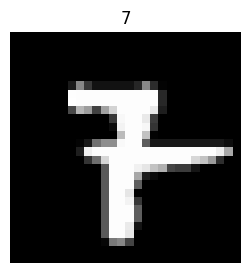

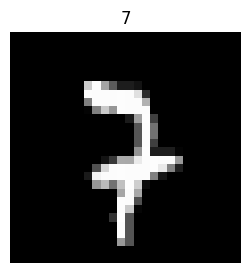

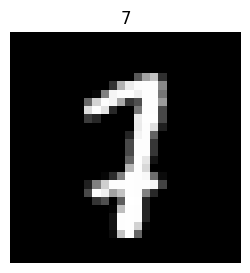

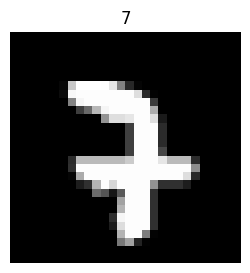

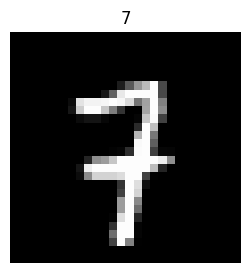

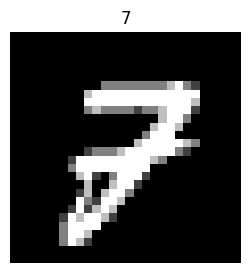

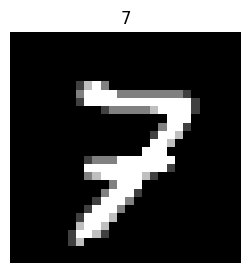

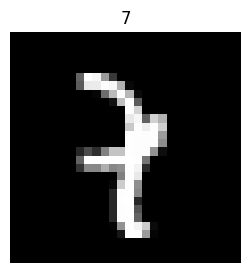

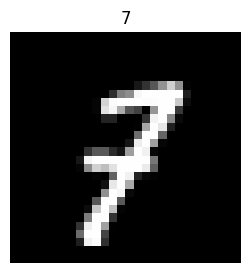

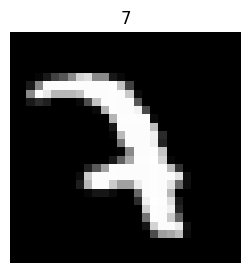

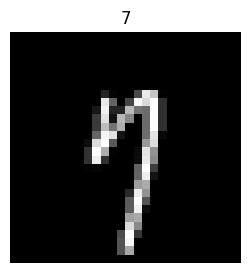

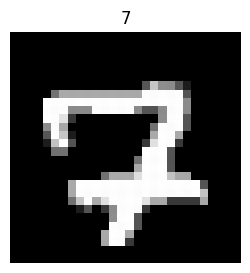

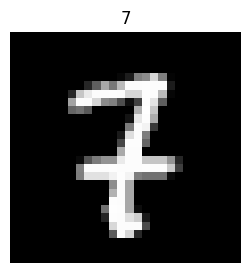

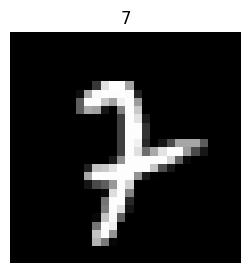

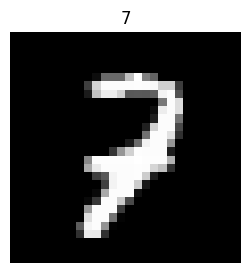

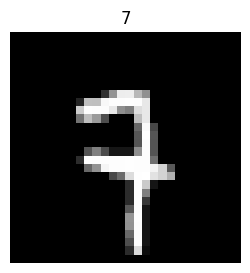

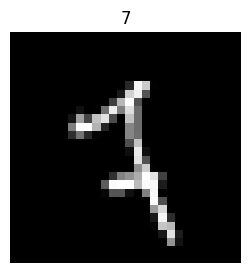

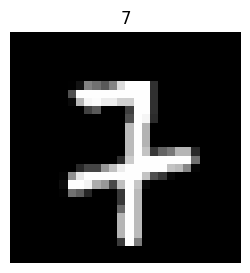

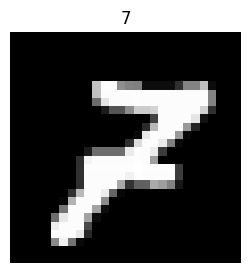

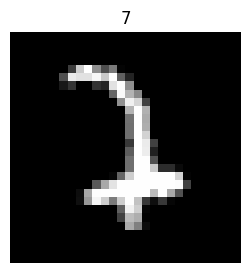

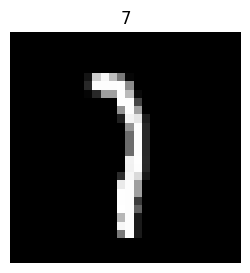

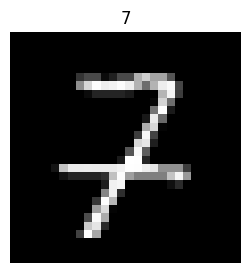

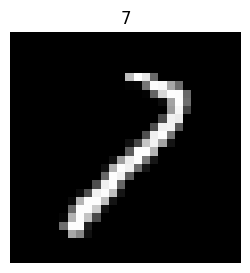

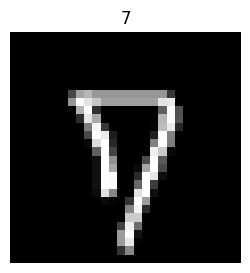

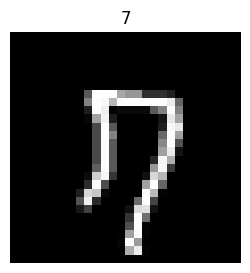

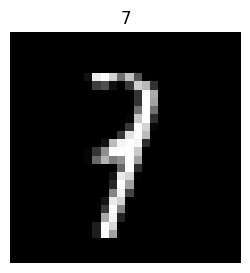

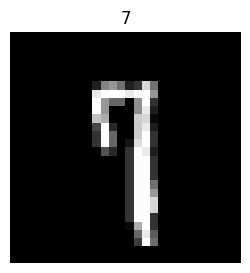

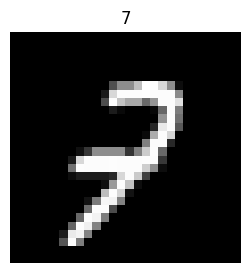

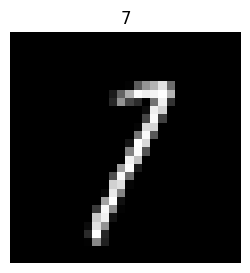

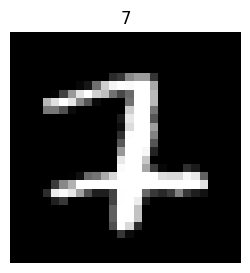

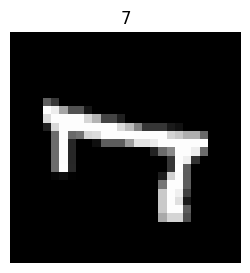

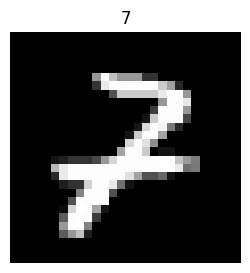

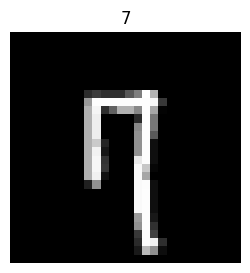

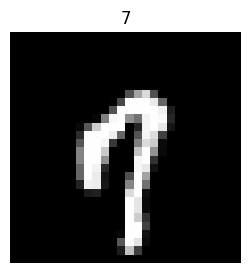

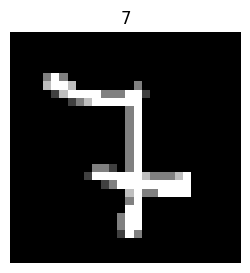

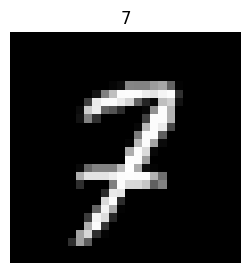

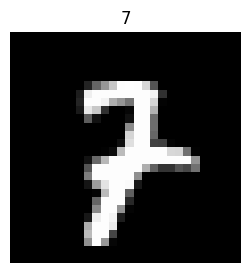

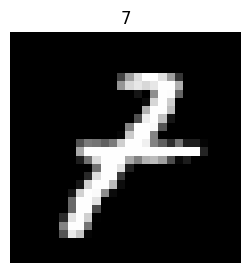

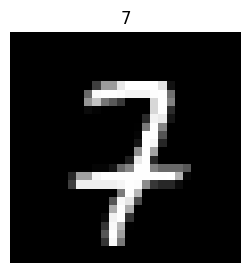

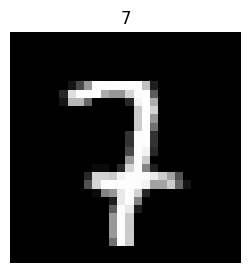

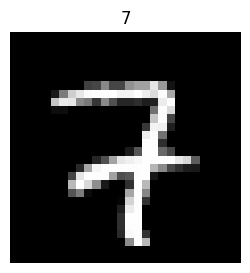

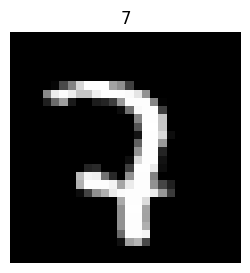

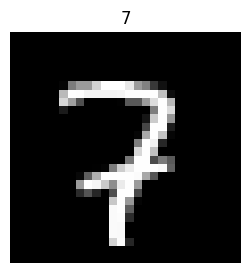

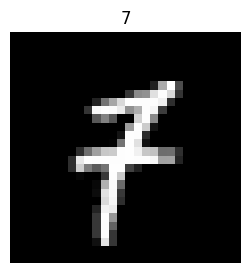

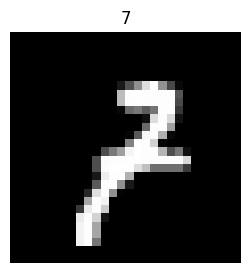

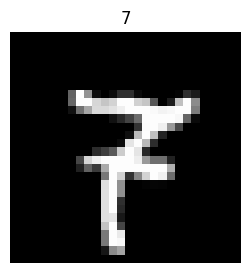

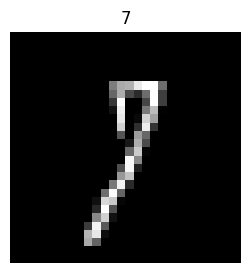

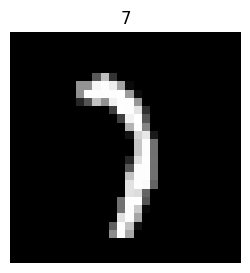

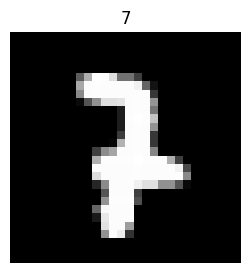

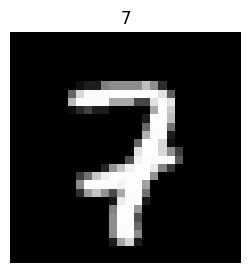

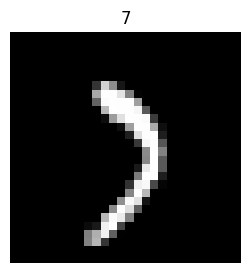

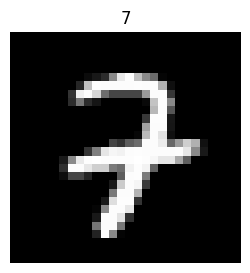

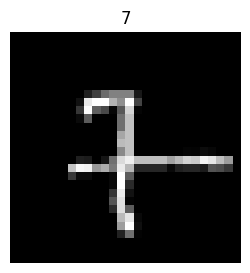

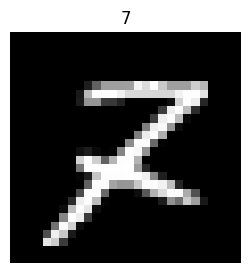

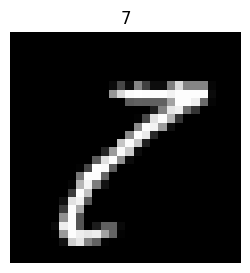

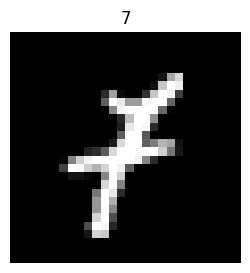

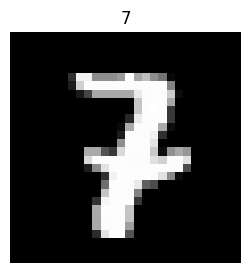

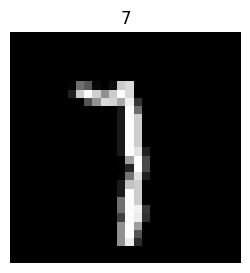

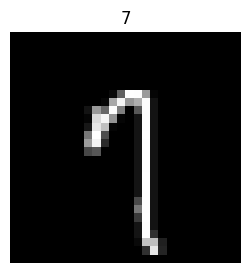

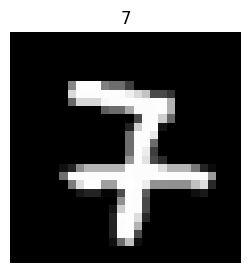

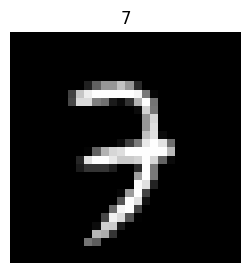

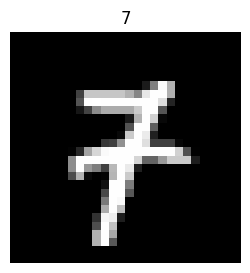

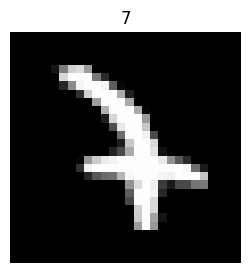

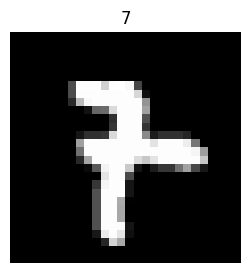

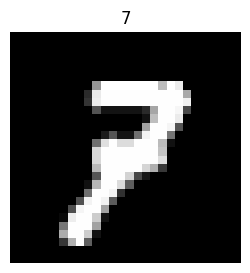

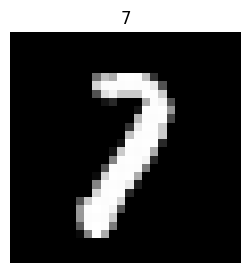

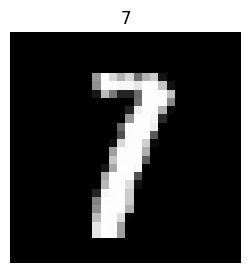

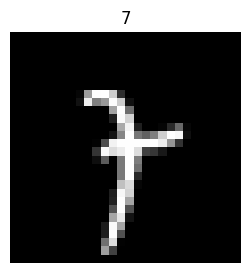

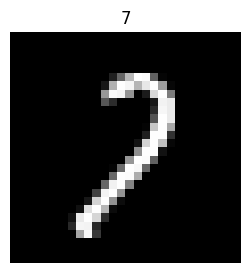

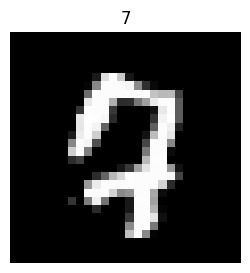

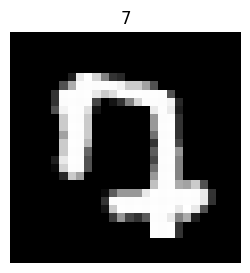

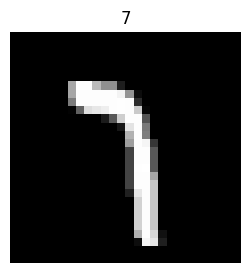

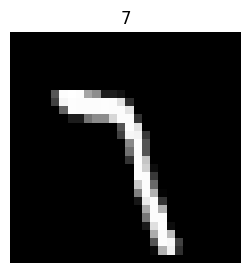

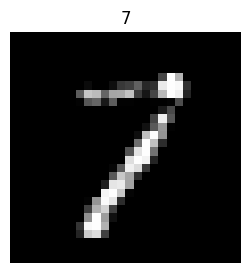

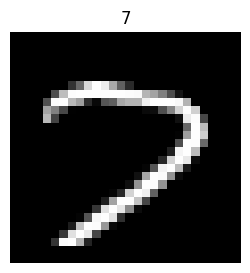

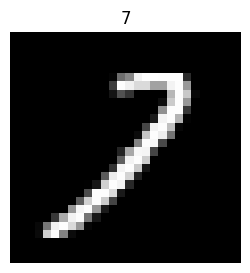

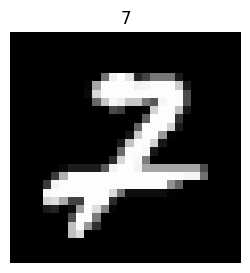

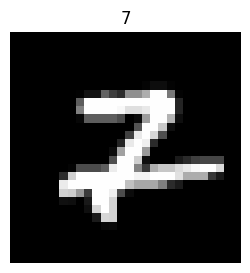

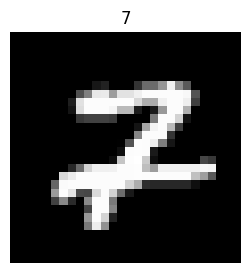

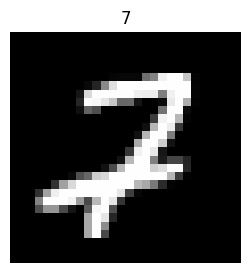

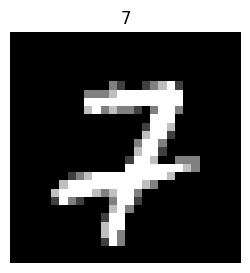

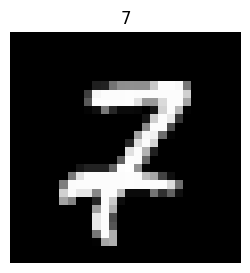

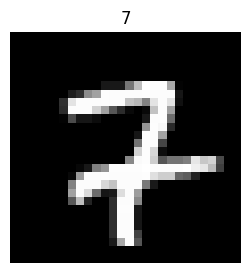

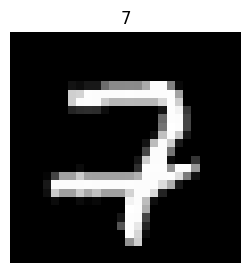

In [36]:
avg_missclassified_as_0 = np.zeros(sae_hidden_dim)
num_wrong_0 = 0
for idx in falsely_identified.keys():
    if falsely_identified[idx] == 0:
        visualize_image(test_images[idx], test_labels[idx])
        avg_missclassified_as_0 += sparse_act_one[idx]
        num_wrong_0 += 1

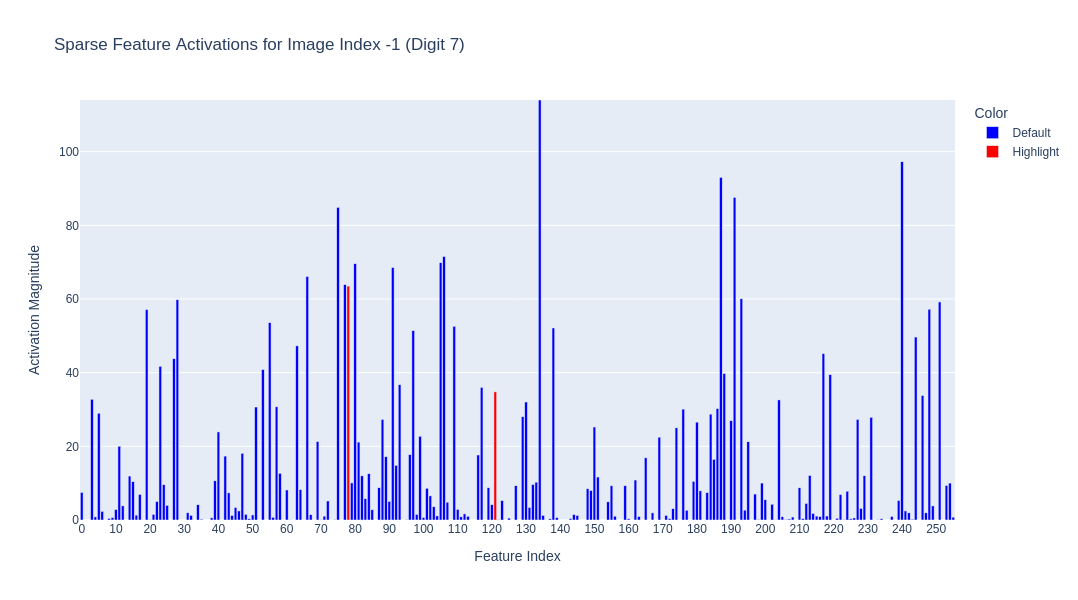

In [37]:
avg_missclassified_as_0 = avg_missclassified_as_0 / num_wrong_0
plot_sparse_features(avg_missclassified_as_0, -1, 7, HIDDEN_SIZE)

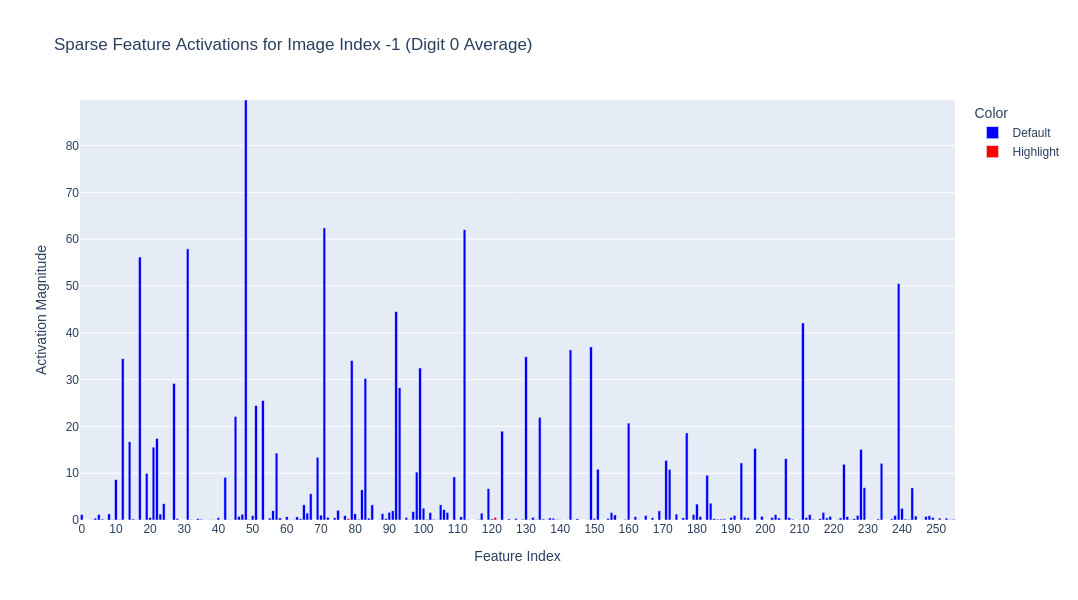

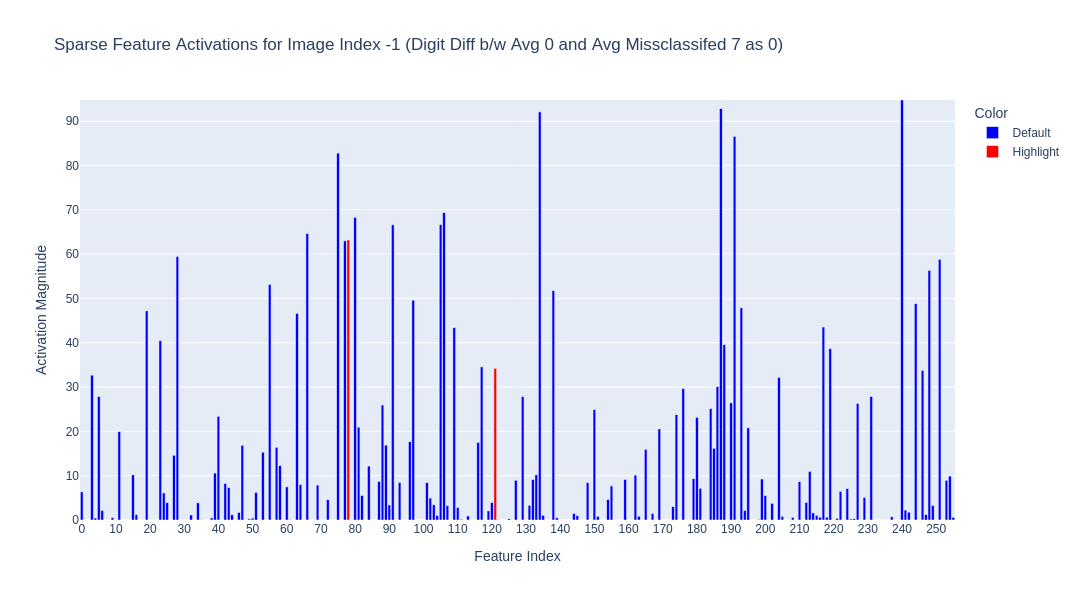

In [43]:
plot_sparse_features(avg_digit_encoding[0], -1, "0 Average", HIDDEN_SIZE)
plot_sparse_features(avg_missclassified_as_0 - avg_digit_encoding[0], -1, "Diff b/w Avg 0 and Avg Missclassifed 7 as 0", HIDDEN_SIZE)

In [57]:
num_corrected_dict = {}

for new_idx in range(HIDDEN_SIZE):
    num_corrected = 0
    if new_idx != 85 and new_idx != 150 and new_idx != 227 and new_idx != 15:
    
        for idx in falsely_identified.keys():
            if falsely_identified[idx] == 0:
                encoded = np.zeros(sae_hidden_dim)
                sparse_vector_digit = sparse_act_one[idx]
        
                # previous 4 key features
                encoded[85] = sparse_vector_digit[85]
                encoded[150] = sparse_vector_digit[150]
                encoded[227] = sparse_vector_digit[227]
                encoded[15] = sparse_vector_digit[15]
        
                # new feature to correct our misclassifed digits:
                encoded[new_idx] = sparse_vector_digit[new_idx]
        
                encoded_digit_torch = torch.from_numpy(encoded).float().to(device).unsqueeze(0)
        
                with torch.no_grad():
                    recon_hidden = best_sae_one.decoder(encoded_digit_torch)
                    recon_hidden = recon_hidden.view(1, -1)
                
                    hidden_two = best_model.hidden_two(recon_hidden)
                    classification_out = best_model.classification_layer(hidden_two)
                
                    probs = torch.softmax(classification_out, dim=1)
                    _, pred = torch.max(classification_out, 1)
        
                    if pred.item() == 7:
                        num_corrected += 1

        num_corrected_dict[new_idx] = num_corrected
        print(f"Number of corrected digits from activating feature {new_idx}: {num_corrected}")

Number of corrected digits from activating feature 0: 0
Number of corrected digits from activating feature 1: 0
Number of corrected digits from activating feature 2: 0
Number of corrected digits from activating feature 3: 0
Number of corrected digits from activating feature 4: 0
Number of corrected digits from activating feature 5: 0
Number of corrected digits from activating feature 6: 0
Number of corrected digits from activating feature 7: 0
Number of corrected digits from activating feature 8: 0
Number of corrected digits from activating feature 9: 0
Number of corrected digits from activating feature 10: 0
Number of corrected digits from activating feature 11: 0
Number of corrected digits from activating feature 12: 0
Number of corrected digits from activating feature 13: 0
Number of corrected digits from activating feature 14: 0
Number of corrected digits from activating feature 16: 0
Number of corrected digits from activating feature 17: 0
Number of corrected digits from activatin

So, it appears these 7s are irrecoverable from our set of encoded sparse features... we should be able to choose a better basis for 7s, at least based on the average score of our linear probes.

### Exploring the 7s Misclassified as 9s

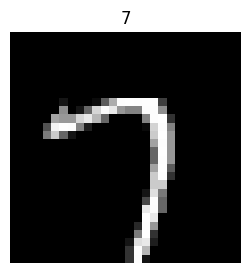

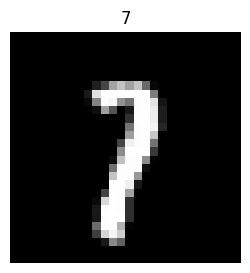

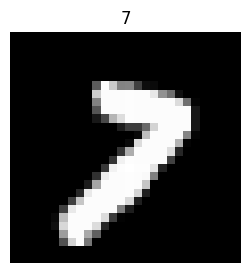

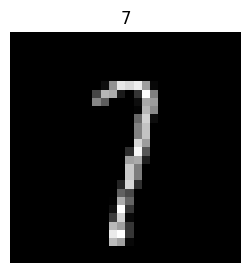

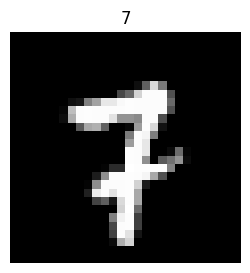

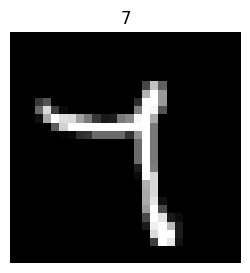

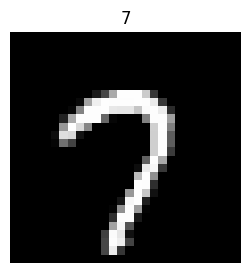

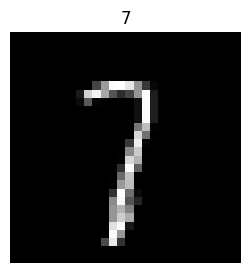

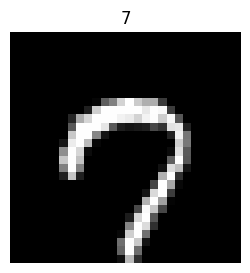

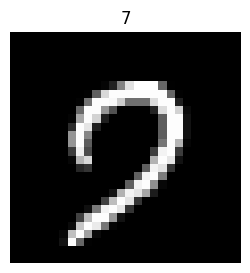

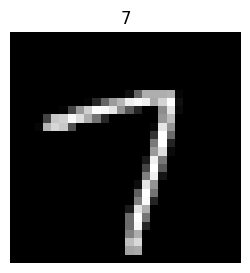

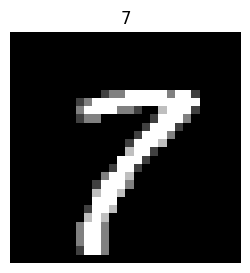

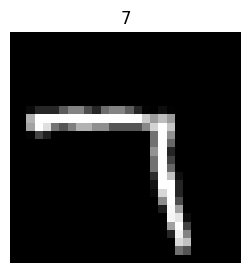

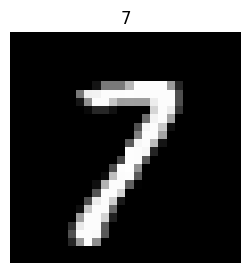

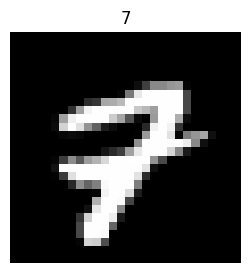

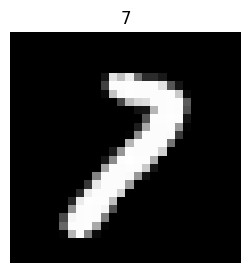

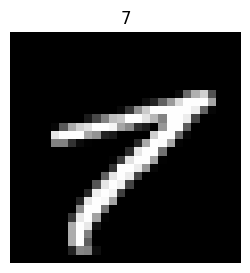

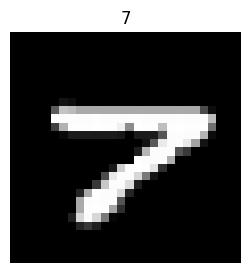

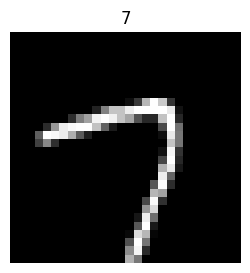

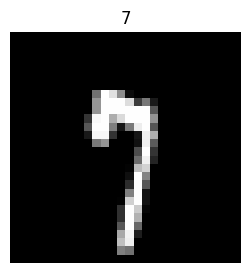

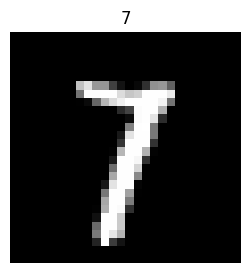

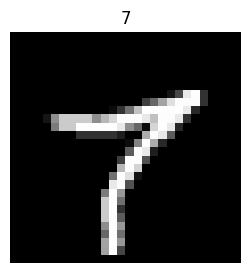

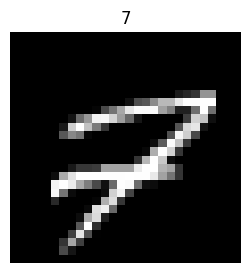

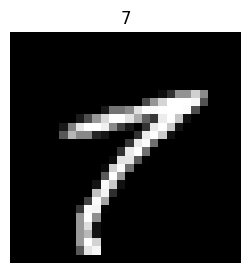

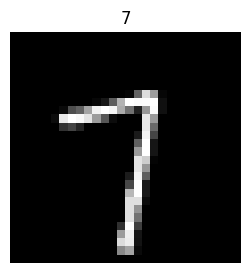

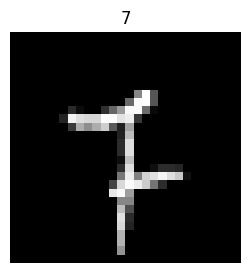

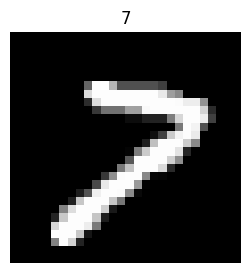

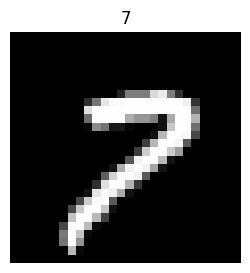

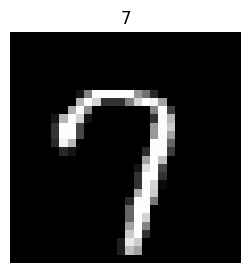

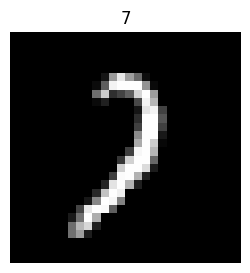

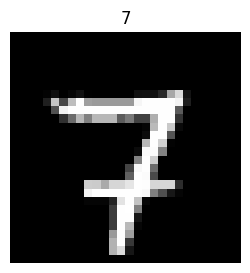

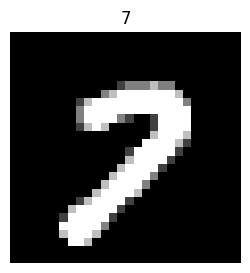

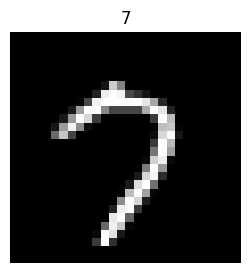

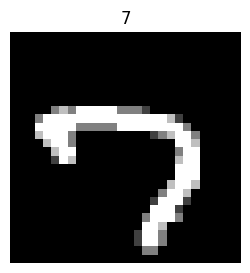

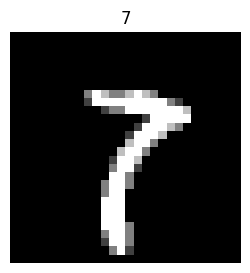

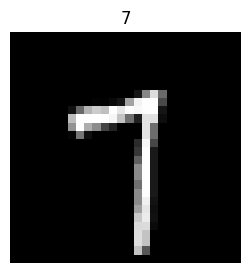

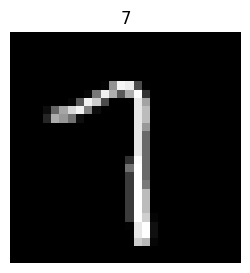

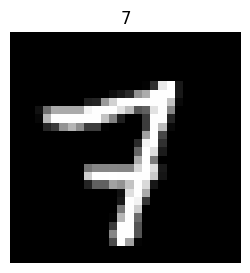

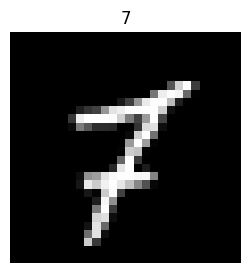

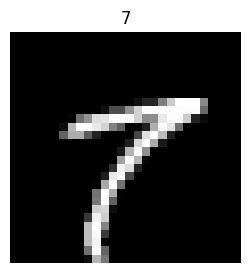

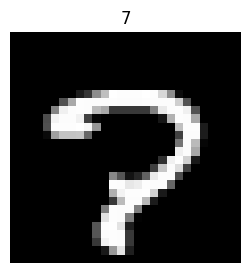

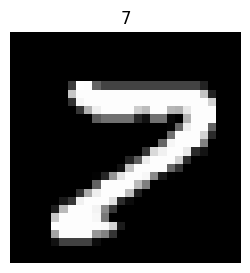

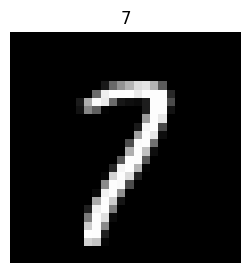

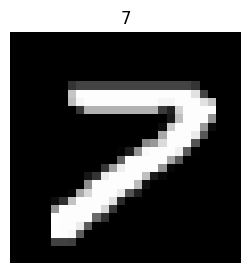

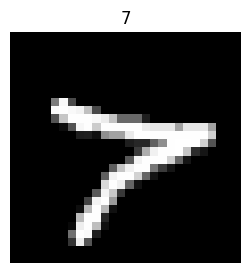

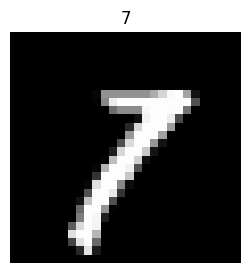

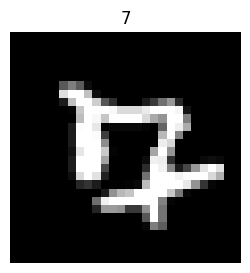

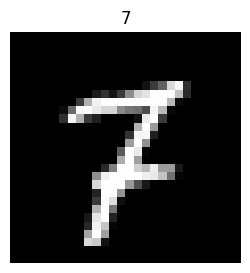

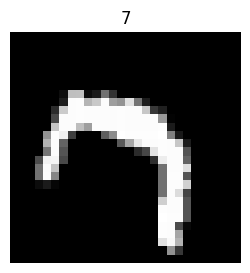

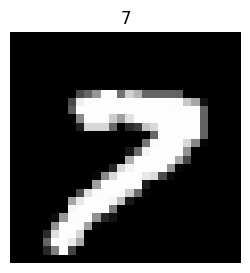

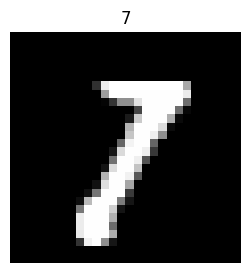

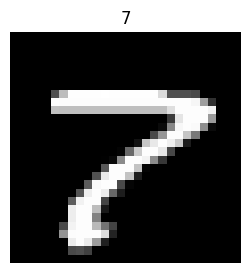

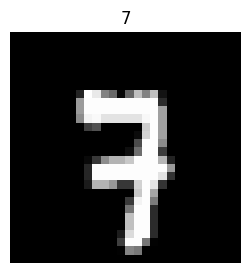

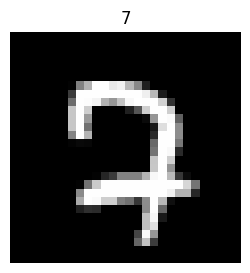

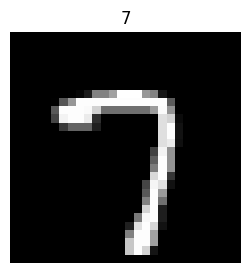

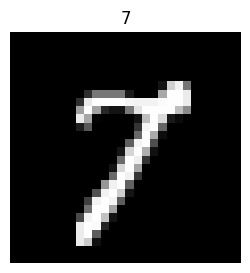

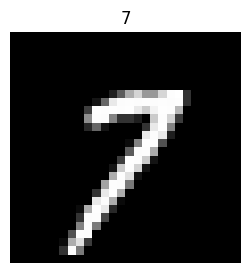

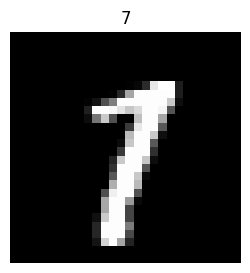

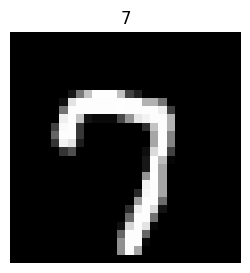

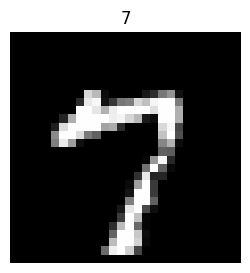

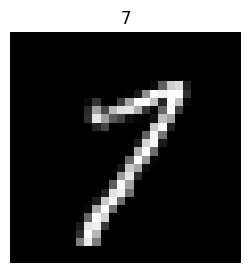

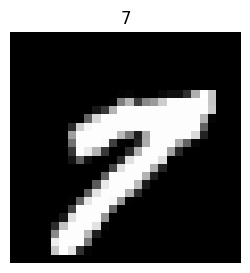

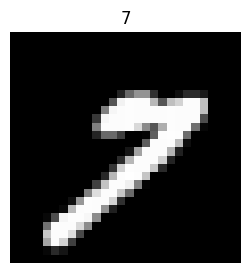

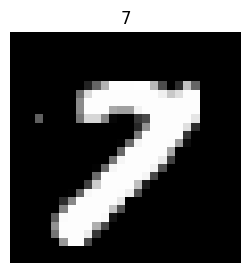

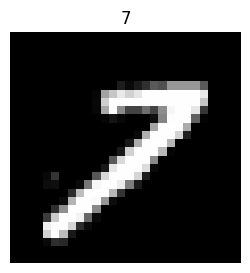

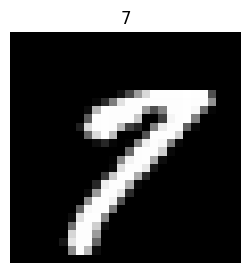

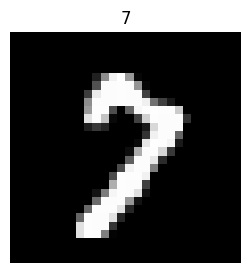

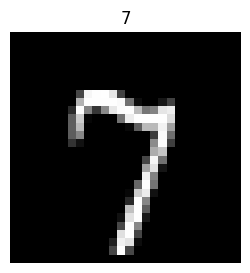

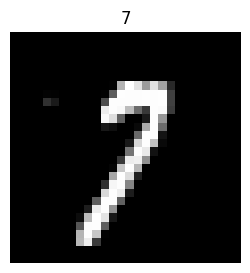

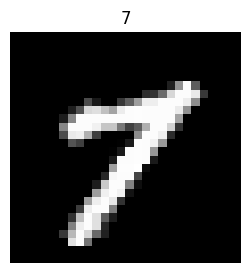

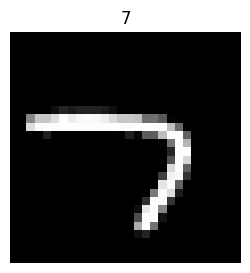

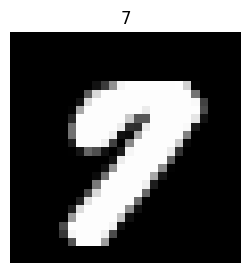

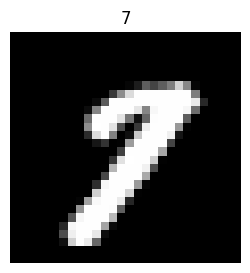

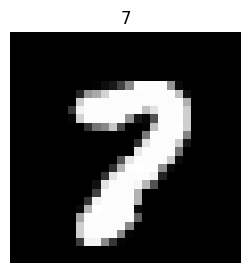

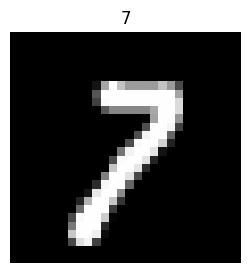

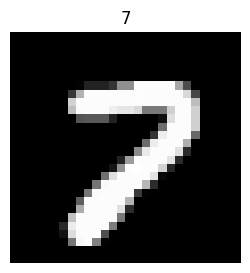

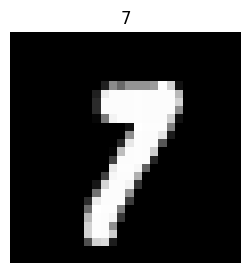

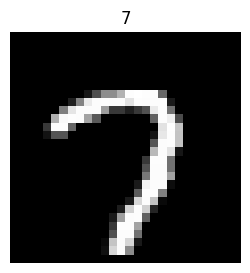

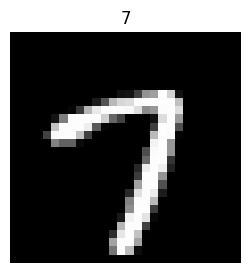

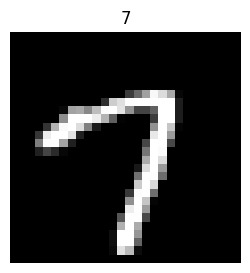

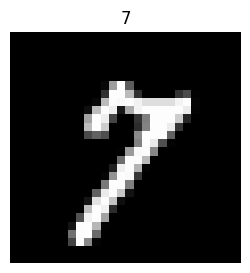

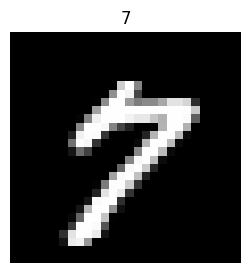

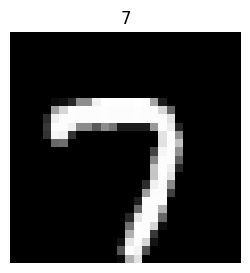

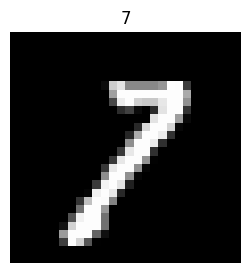

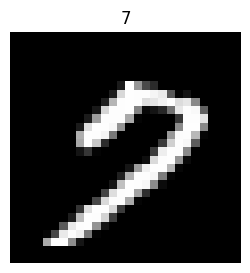

In [34]:
avg_missclassified_as_9 = np.zeros(sae_hidden_dim)
num_wrong_9 = 0
for idx in falsely_identified.keys():
    if falsely_identified[idx] != 0:
        visualize_image(test_images[idx], test_labels[idx])
        avg_missclassified_as_9 += sparse_act_one[idx]
        num_wrong_9 += 1

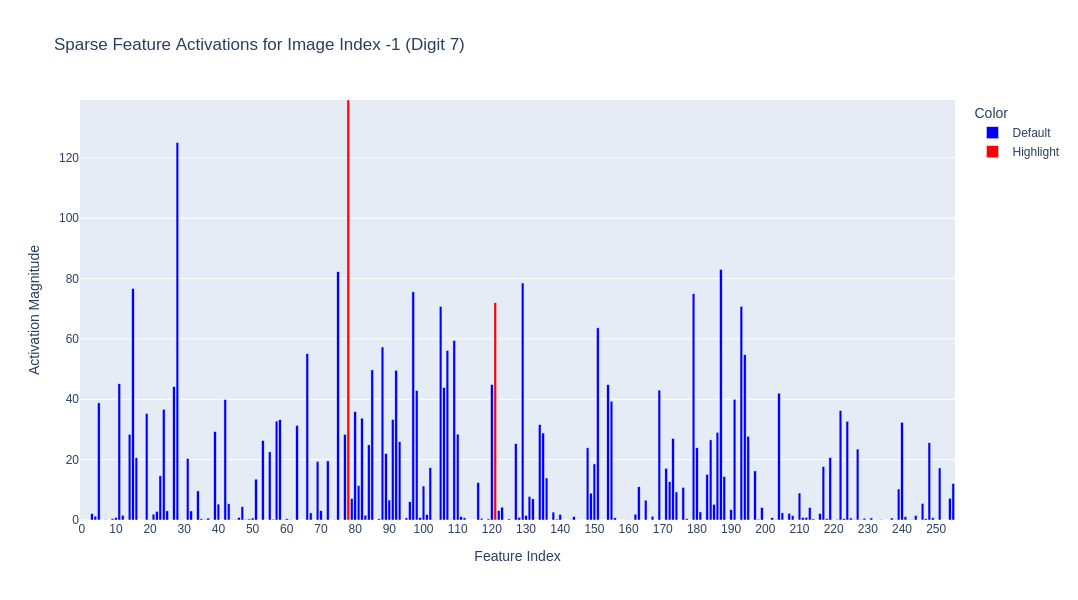

In [35]:
avg_missclassified_as_9 = avg_missclassified_as_9 / num_wrong_9
plot_sparse_features(avg_missclassified_as_9, -1, 7, HIDDEN_SIZE)

In [58]:
num_corrected_dict = {}

for new_idx in range(HIDDEN_SIZE):
    num_corrected = 0
    if new_idx != 85 and new_idx != 150 and new_idx != 227 and new_idx != 15:
    
        for idx in falsely_identified.keys():
            if falsely_identified[idx] != 0:
                encoded = np.zeros(sae_hidden_dim)
                sparse_vector_digit = sparse_act_one[idx]
        
                # previous 4 key features
                encoded[85] = sparse_vector_digit[85]
                encoded[150] = sparse_vector_digit[150]
                encoded[227] = sparse_vector_digit[227]
                encoded[15] = sparse_vector_digit[15]
        
                # new feature to correct our misclassifed digits:
                encoded[new_idx] = sparse_vector_digit[new_idx]
        
                encoded_digit_torch = torch.from_numpy(encoded).float().to(device).unsqueeze(0)
        
                with torch.no_grad():
                    recon_hidden = best_sae_one.decoder(encoded_digit_torch)
                    recon_hidden = recon_hidden.view(1, -1)
                
                    hidden_two = best_model.hidden_two(recon_hidden)
                    classification_out = best_model.classification_layer(hidden_two)
                
                    probs = torch.softmax(classification_out, dim=1)
                    _, pred = torch.max(classification_out, 1)
        
                    if pred.item() == 7:
                        num_corrected += 1

        num_corrected_dict[new_idx] = num_corrected
        print(f"Number of corrected digits from activating feature {new_idx}: {num_corrected}")

Number of corrected digits from activating feature 0: 0
Number of corrected digits from activating feature 1: 0
Number of corrected digits from activating feature 2: 0
Number of corrected digits from activating feature 3: 0
Number of corrected digits from activating feature 4: 0
Number of corrected digits from activating feature 5: 0
Number of corrected digits from activating feature 6: 0
Number of corrected digits from activating feature 7: 0
Number of corrected digits from activating feature 8: 0
Number of corrected digits from activating feature 9: 0
Number of corrected digits from activating feature 10: 0
Number of corrected digits from activating feature 11: 0
Number of corrected digits from activating feature 12: 0
Number of corrected digits from activating feature 13: 0
Number of corrected digits from activating feature 14: 0
Number of corrected digits from activating feature 16: 0
Number of corrected digits from activating feature 17: 0
Number of corrected digits from activatin

A lot of these are still clearly 7s, despite being rather whack 7s. Another interesting point is that the 7s that tend to be misclassified as 0s are "bulky" in the middle (usually due to the horizontal slash in the middle of the 7, I'd guess).

Whereas our misclassifed 7s as 9s tend to have a droppy curl (close to closing the loop and becoming a 9) or a sharp but small loop, which is also close to closing the loop and making a 9.

Also, it seems that our basis for identifying 7s is relatively poor. As our linear probes has around 90% accuracy, but it seems that our choosen basis can't be corrected to acheive higher than 83% accuracy, at least with adding one more feature to our choosen set of four.

# Turning Off Key Features

What happens if we turn off key 7 features?

In [44]:
num_7s = 0
correctly_identified_ablation = 0
falsely_identified_ablation = {}

for i, label in enumerate(test_labels):
    if label == 7:
        num_7s += 1
        
        encoded = sparse_act_one[i]
    
        encoded[85] = 0
        encoded[150] = 0
        encoded[227] = 0

        encoded_digit_torch = torch.from_numpy(encoded).float().to(device).unsqueeze(0)

        with torch.no_grad():
            recon_hidden_6079 = best_sae_one.decoder(encoded_digit_torch)
            recon_hidden_6079 = recon_hidden_6079.view(1, -1)
        
            hidden_two = best_model.hidden_two(recon_hidden_6079)
            classification_out = best_model.classification_layer(hidden_two)
        
            probs = torch.softmax(classification_out, dim=1)
            _, pred = torch.max(classification_out, 1)

            if label == pred.item():
                correctly_identified_ablation += 1
            else:
                falsely_identified_ablation[i] = pred.item()

print(f"The number of correctly identified 7s: {correctly_identified_ablation}")
print(f"The number of incorrectly identified 7s: {len(falsely_identified_ablation)}")
print(f"Percentage correct: {round(correctly_identified_ablation / num_7s * 100, 3)}%")

The number of correctly identified 7s: 15
The number of incorrectly identified 7s: 1013
Percentage correct: 1.459%


Really, really bad... so yes, it does seem that 85, 150, and 227 are quite important for classifying 7s.

Out of curiousity, let's go one step further and also remove feature 15, since it gave us an 83.56% accuracy with the other three features:

In [45]:
num_7s = 0
correctly_identified_ablation = 0
falsely_identified_ablation = {}

for i, label in enumerate(test_labels):
    if label == 7:
        num_7s += 1
        
        encoded = sparse_act_one[i]
    
        encoded[85] = 0
        encoded[150] = 0
        encoded[227] = 0
        encoded[15] = 0

        encoded_digit_torch = torch.from_numpy(encoded).float().to(device).unsqueeze(0)

        with torch.no_grad():
            recon_hidden_6079 = best_sae_one.decoder(encoded_digit_torch)
            recon_hidden_6079 = recon_hidden_6079.view(1, -1)
        
            hidden_two = best_model.hidden_two(recon_hidden_6079)
            classification_out = best_model.classification_layer(hidden_two)
        
            probs = torch.softmax(classification_out, dim=1)
            _, pred = torch.max(classification_out, 1)

            if label == pred.item():
                correctly_identified_ablation += 1
            else:
                falsely_identified_ablation[i] = pred.item()

print(f"The number of correctly identified 7s: {correctly_identified_ablation}")
print(f"The number of incorrectly identified 7s: {len(falsely_identified_ablation)}")
print(f"Percentage correct: {round(correctly_identified_ablation / num_7s * 100, 3)}%")

The number of correctly identified 7s: 15
The number of incorrectly identified 7s: 1013
Percentage correct: 1.459%


Little difference.

In [47]:
falsely_identified_ablation.values()

dict_values([9, 8, 9, 9, 9, 9, 9, 9, 1, 9, 9, 9, 9, 9, 8, 8, 8, 9, 9, 8, 9, 8, 9, 8, 9, 9, 9, 8, 8, 8, 8, 9, 9, 8, 8, 8, 9, 9, 9, 8, 9, 9, 9, 9, 9, 9, 8, 8, 9, 8, 9, 8, 8, 9, 9, 9, 8, 8, 8, 9, 9, 9, 9, 9, 8, 9, 8, 8, 8, 8, 9, 9, 9, 9, 8, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 8, 9, 8, 9, 8, 9, 9, 8, 8, 9, 9, 8, 9, 8, 9, 9, 8, 9, 9, 9, 9, 8, 8, 9, 9, 9, 8, 8, 9, 9, 9, 9, 9, 8, 8, 9, 8, 9, 9, 8, 8, 8, 9, 8, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 8, 9, 9, 9, 9, 9, 9, 8, 9, 9, 9, 9, 8, 8, 8, 9, 9, 8, 9, 8, 9, 9, 9, 8, 8, 9, 8, 8, 8, 9, 9, 9, 9, 9, 8, 9, 9, 8, 9, 9, 9, 8, 9, 9, 8, 9, 9, 8, 9, 9, 9, 9, 9, 9, 8, 9, 9, 9, 9, 9, 9, 9, 9, 8, 9, 9, 9, 9, 8, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 8, 8, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 8, 8, 9, 9, 9, 8, 9, 8, 8, 9, 9, 8, 9, 9, 9, 9, 8, 9, 8, 9, 9, 8, 9, 9, 9, 9, 8, 8, 9, 9, 9, 8, 8, 9, 9, 9, 9, 9, 9, 9, 9, 8, 8, 8, 8, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 8, 9, 9, 9, 9, 9, 9, 8, 9, 9, 9, 8, 9, 9, 8, 9, 9, 8, 8, 9, 9, 9, 8, 

Seems to make sense that a lot of the 7s get classifed as 9s, since these features helped us differentiate from 9s.

Interesting to see the 8s and 1s.

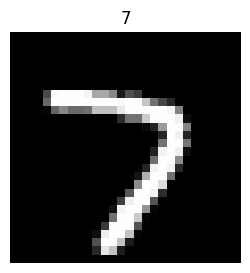

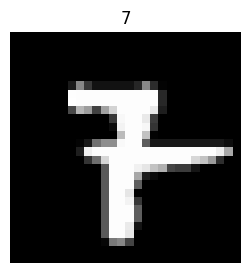

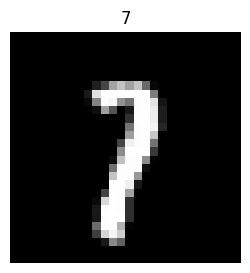

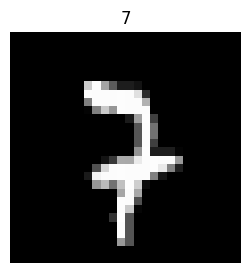

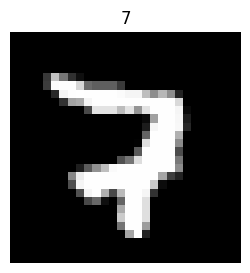

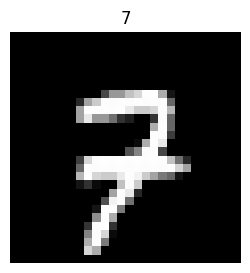

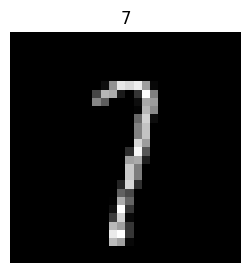

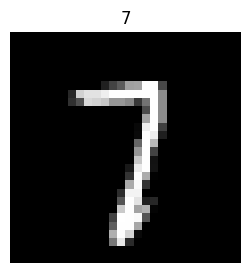

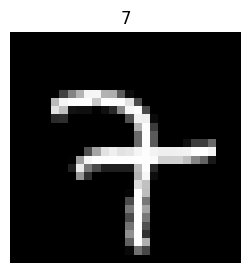

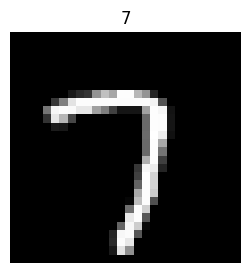

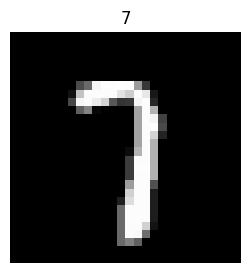

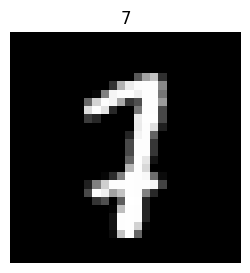

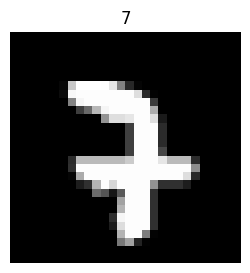

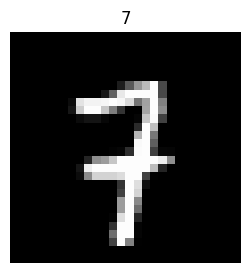

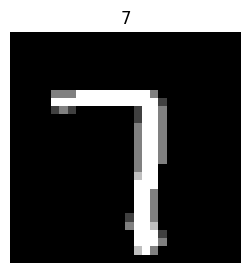

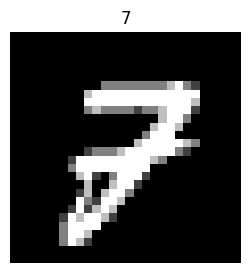

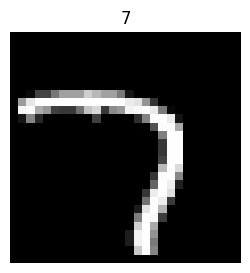

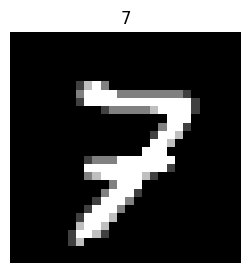

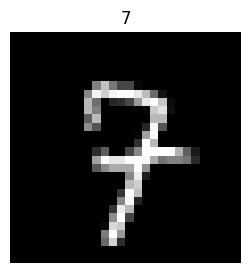

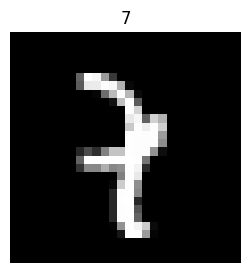

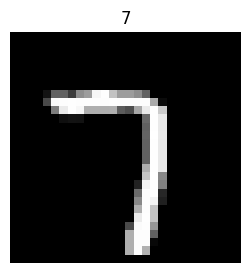

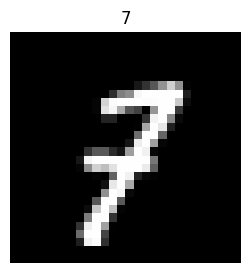

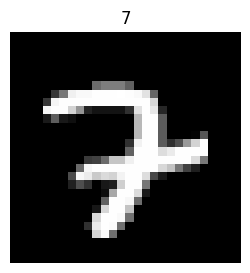

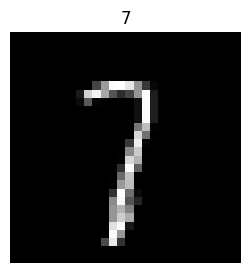

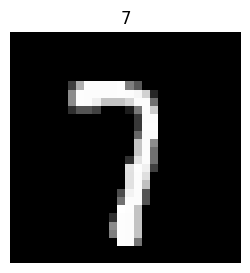

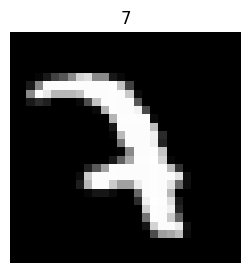

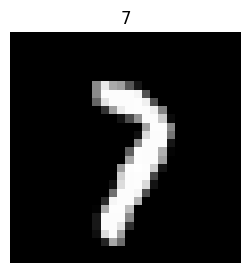

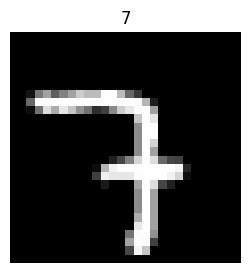

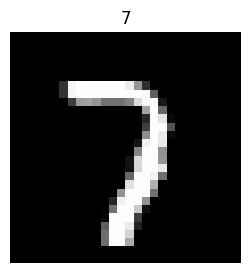

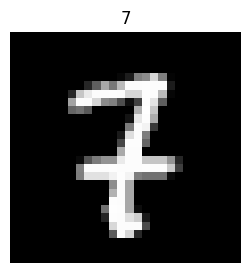

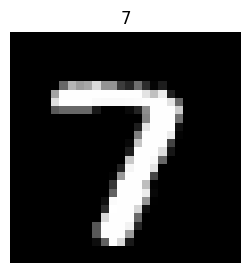

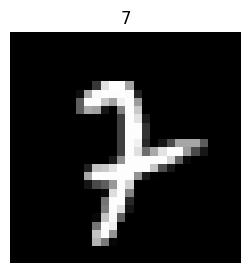

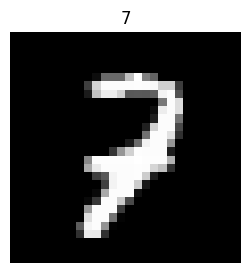

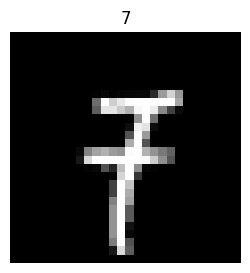

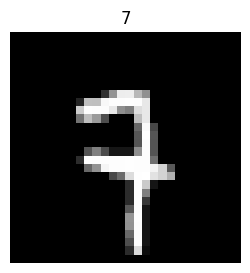

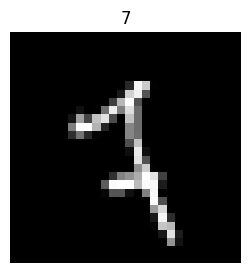

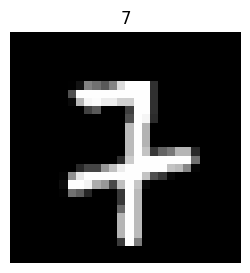

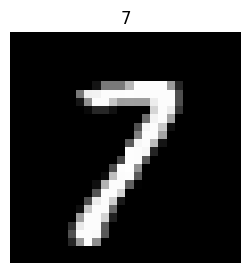

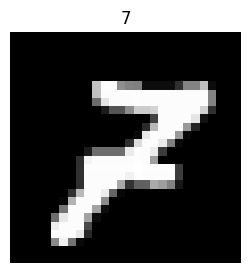

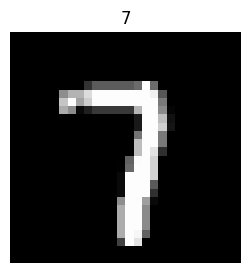

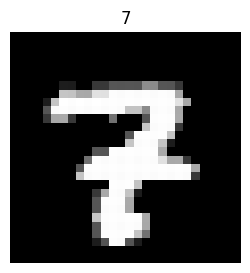

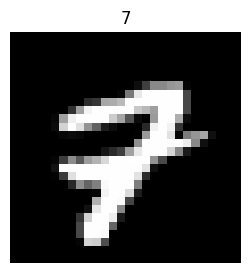

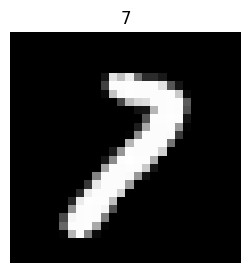

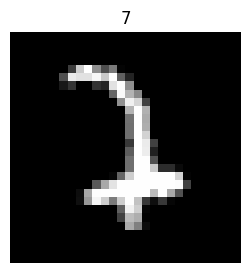

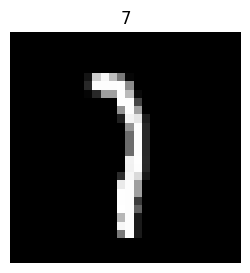

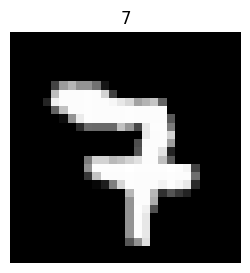

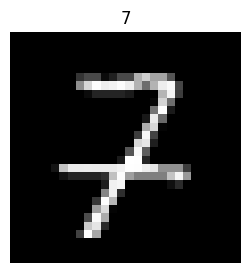

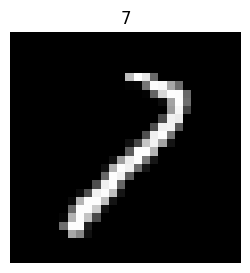

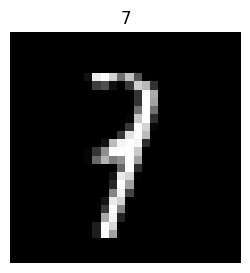

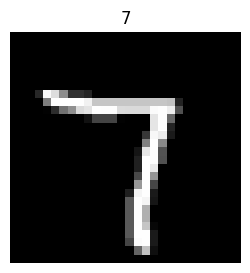

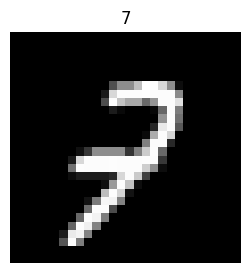

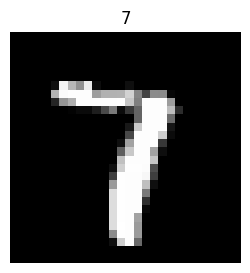

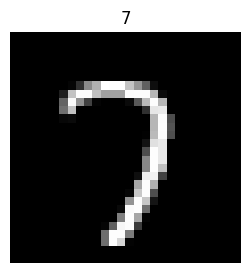

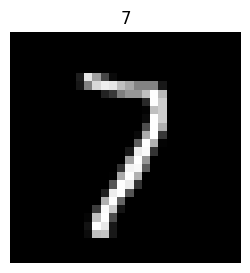

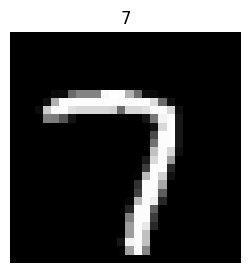

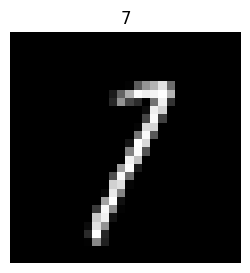

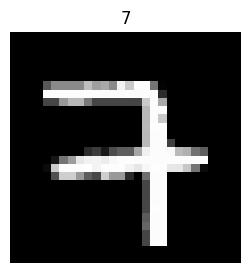

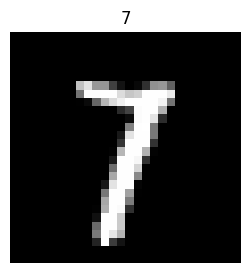

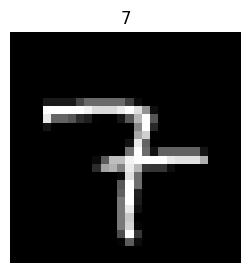

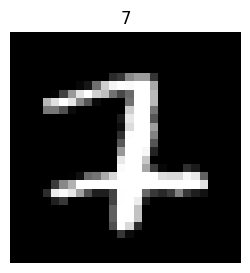

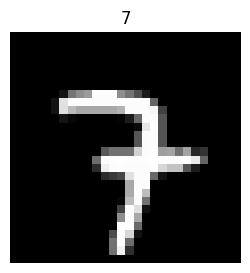

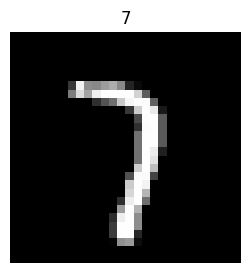

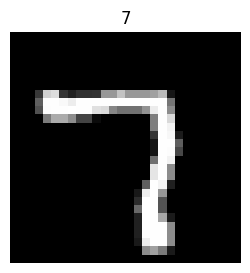

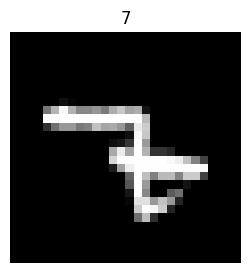

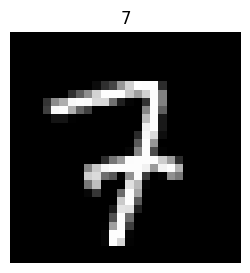

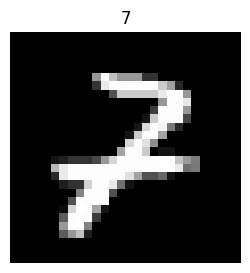

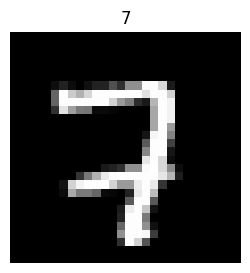

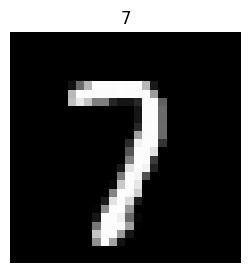

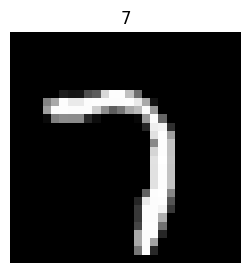

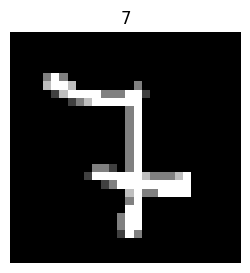

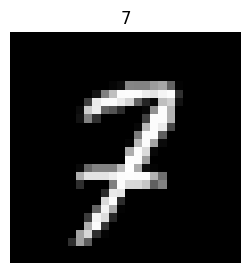

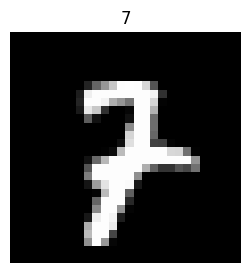

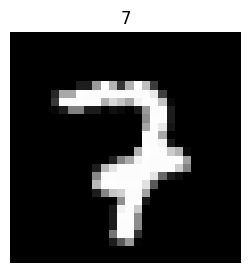

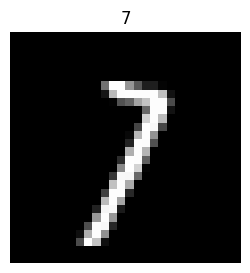

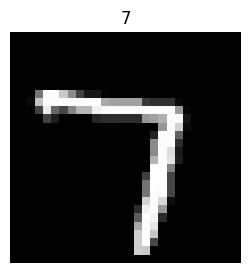

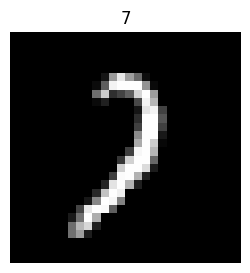

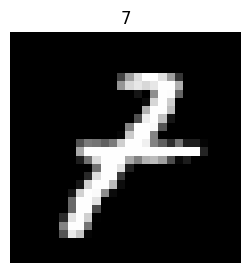

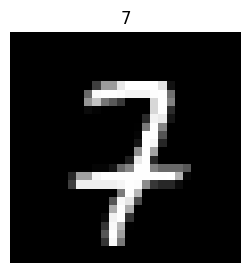

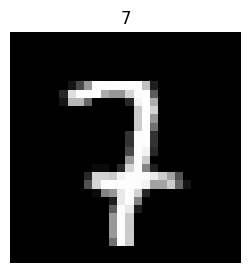

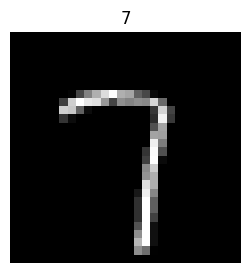

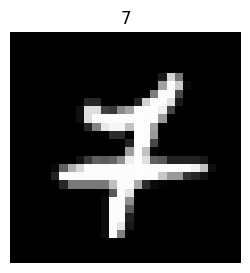

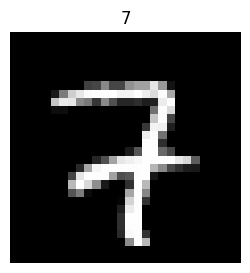

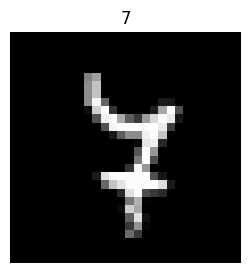

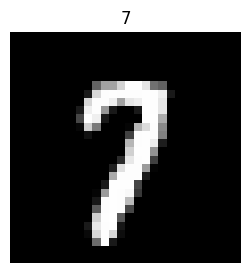

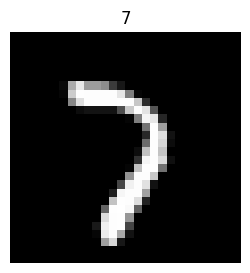

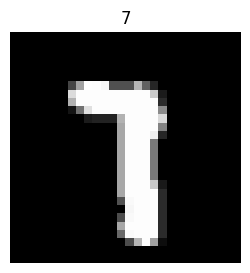

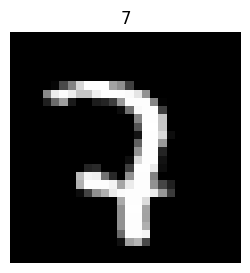

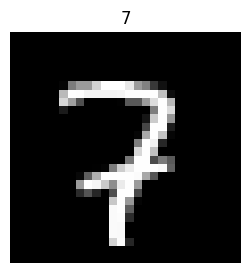

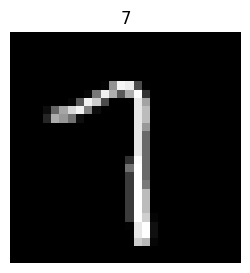

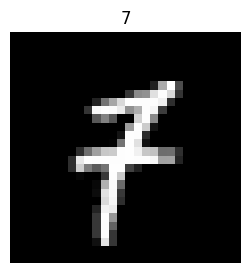

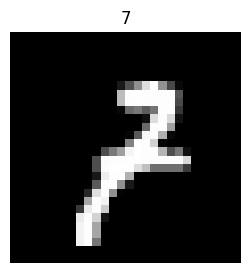

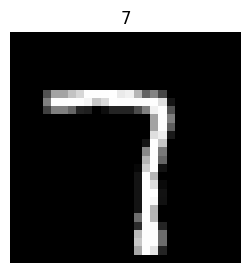

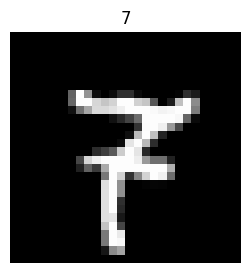

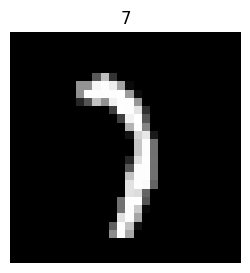

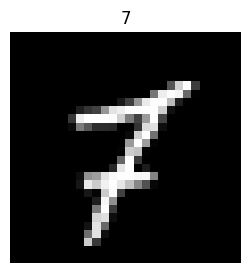

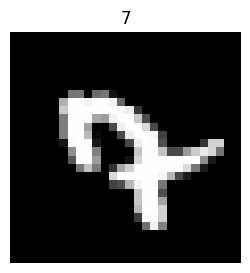

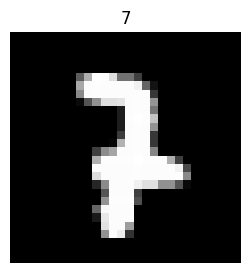

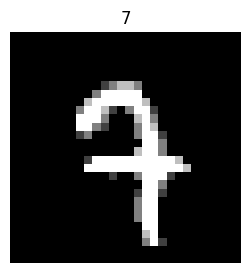

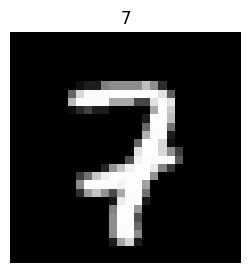

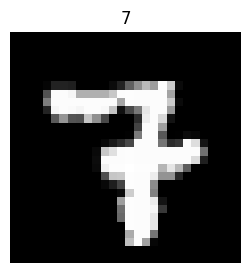

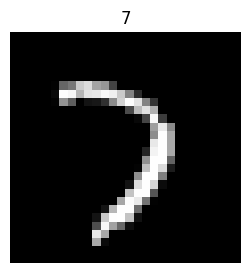

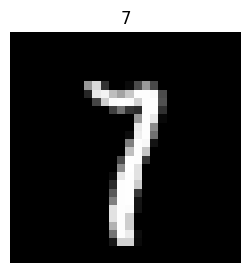

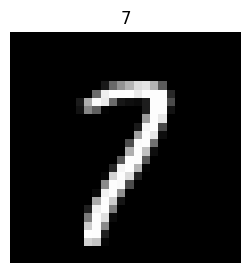

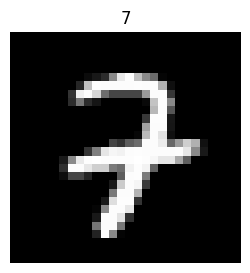

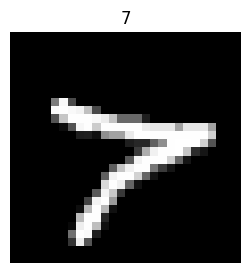

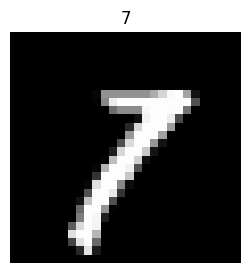

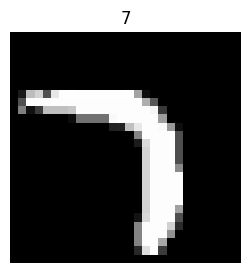

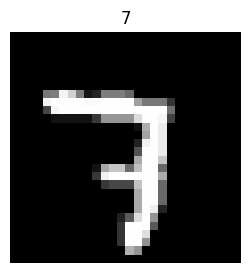

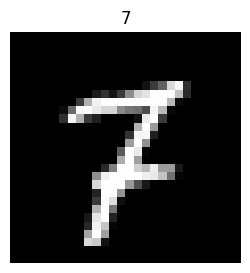

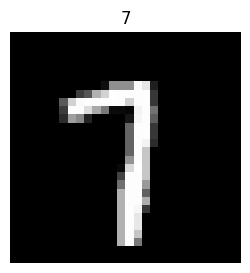

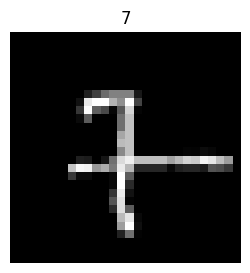

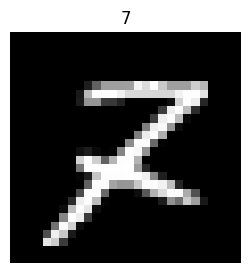

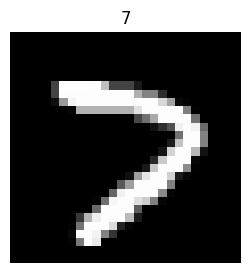

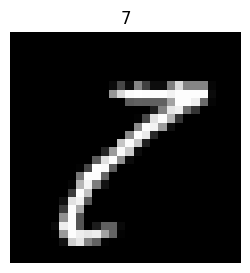

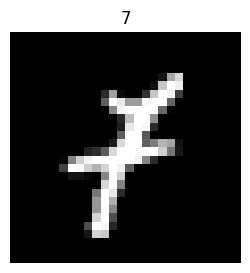

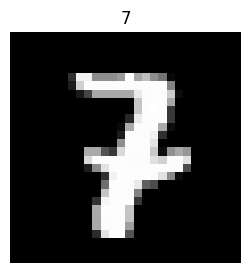

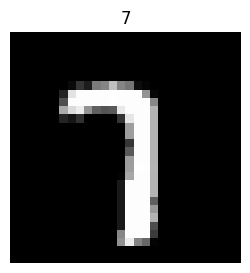

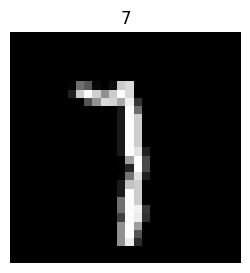

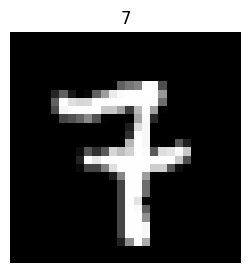

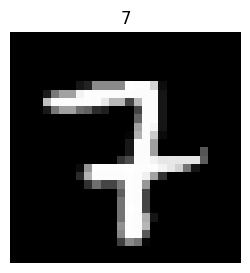

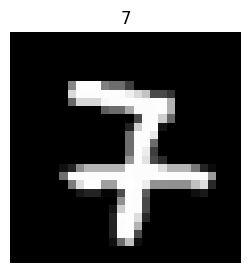

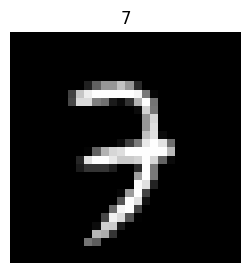

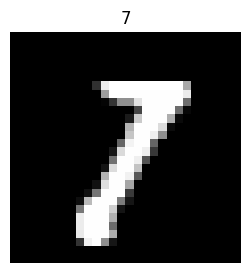

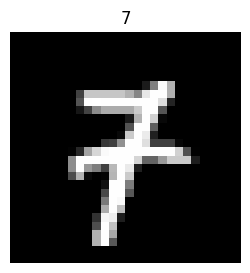

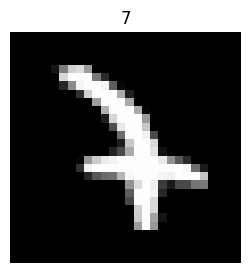

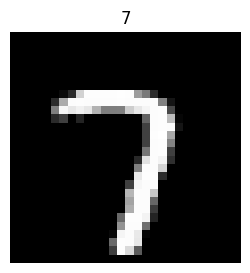

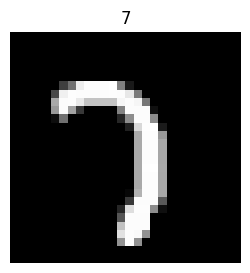

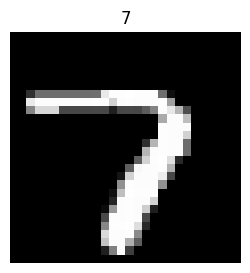

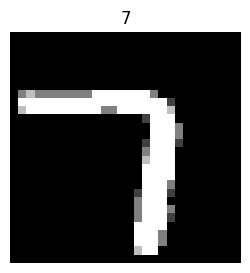

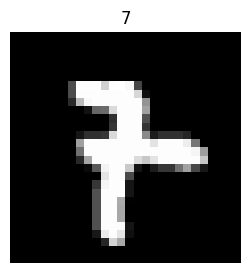

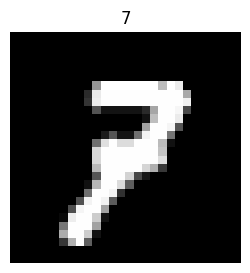

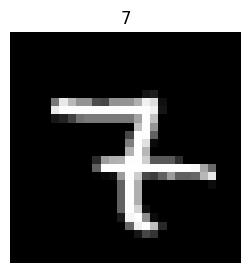

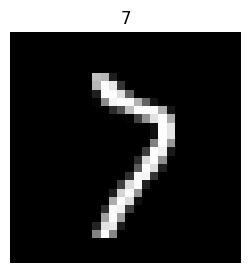

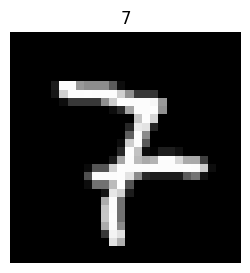

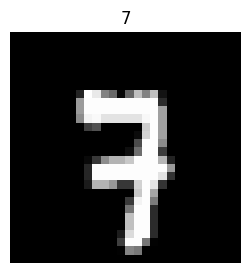

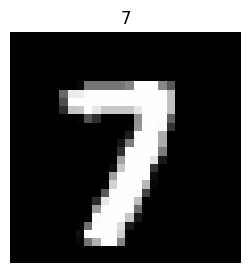

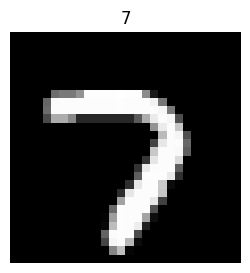

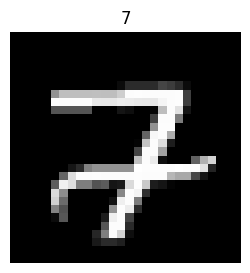

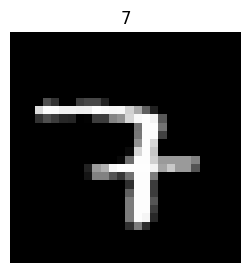

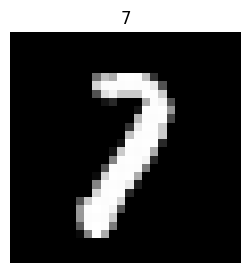

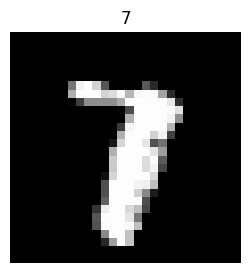

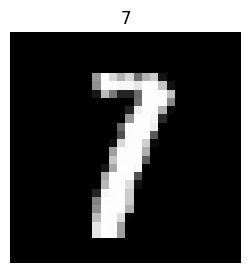

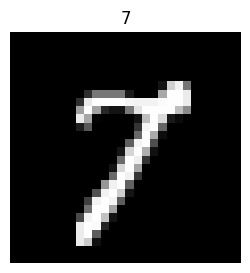

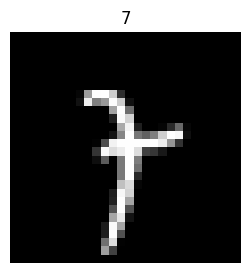

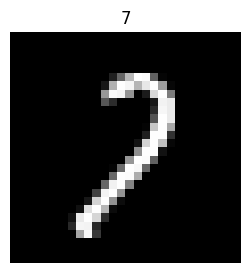

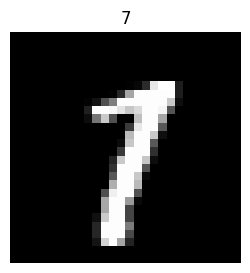

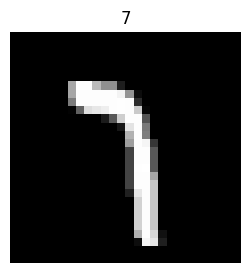

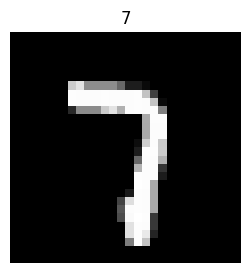

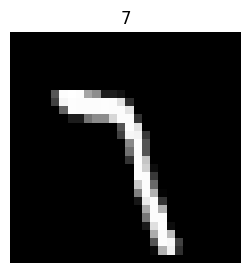

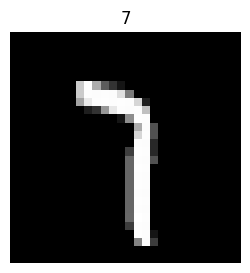

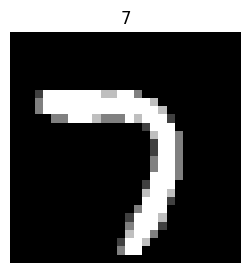

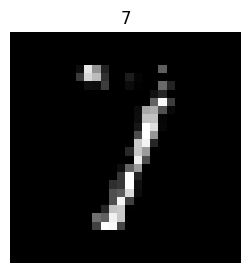

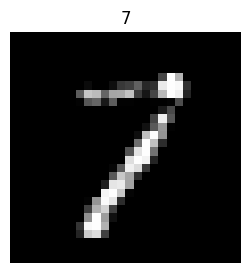

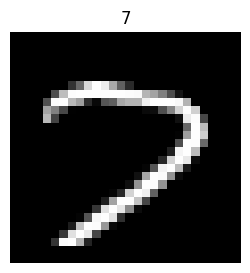

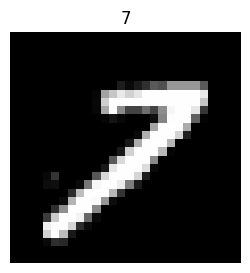

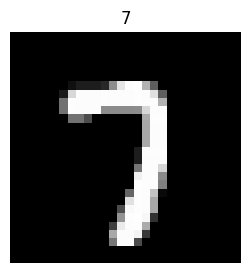

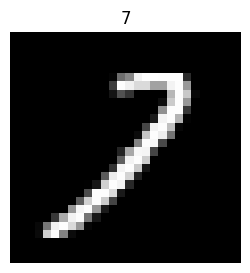

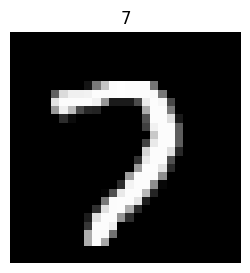

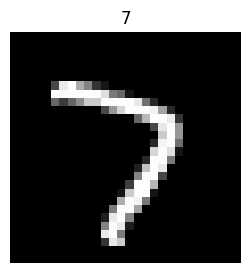

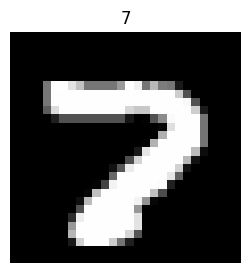

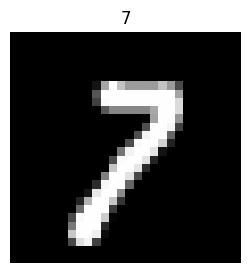

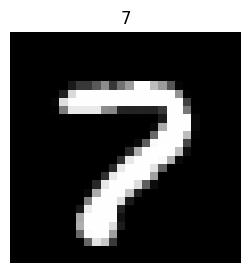

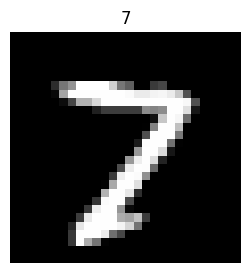

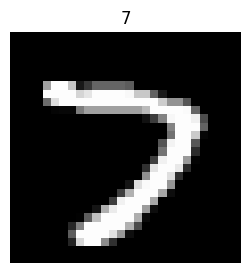

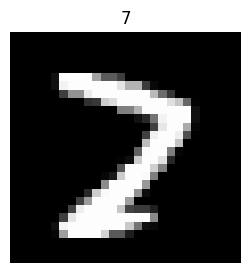

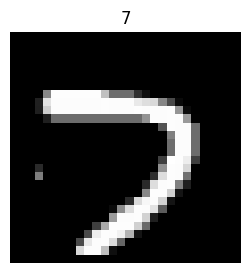

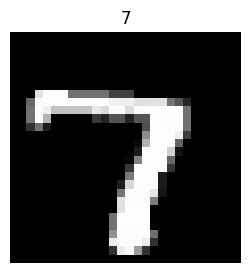

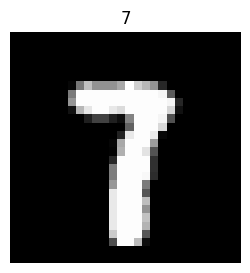

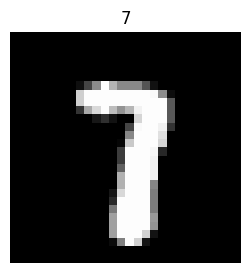

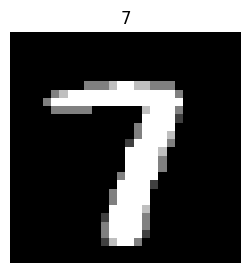

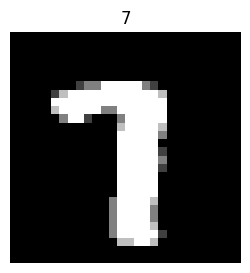

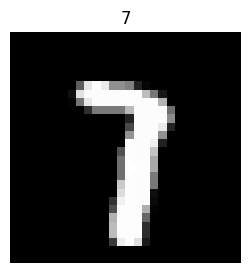

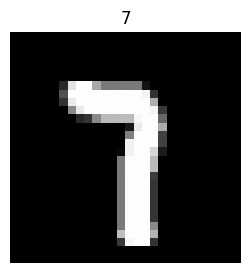

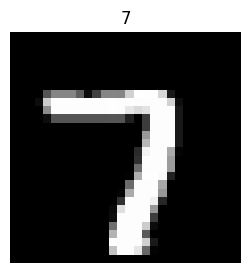

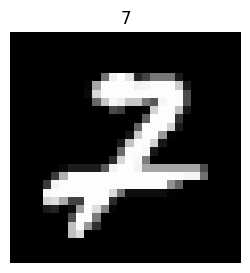

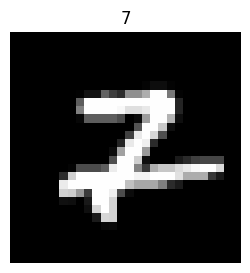

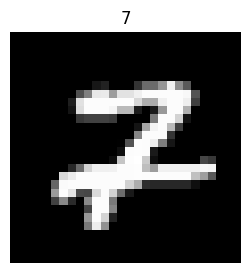

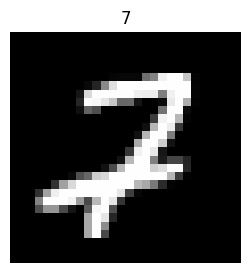

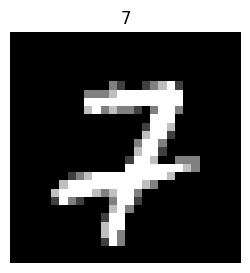

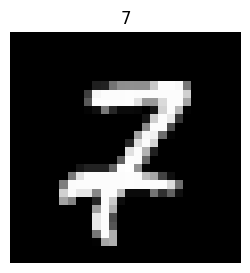

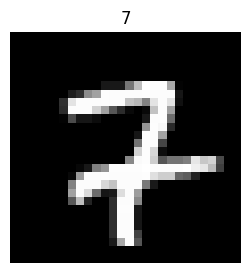

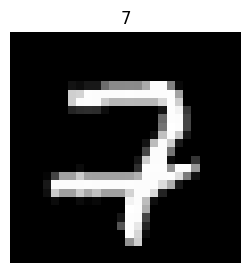

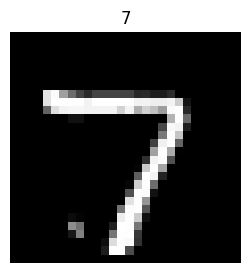

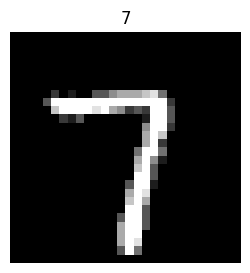

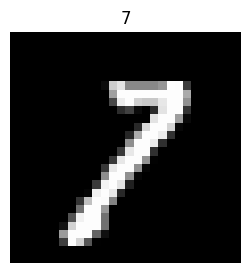

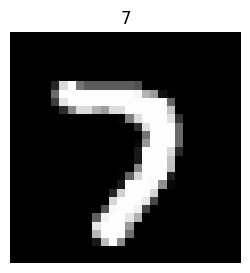

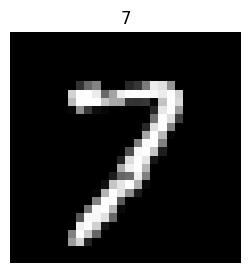

In [49]:
for idx in falsely_identified_ablation.keys():
    if falsely_identified_ablation[idx] == 8:
        visualize_image(test_images[idx], test_labels[idx])

Hard to tell how these become 8s, but it is with feature removal...

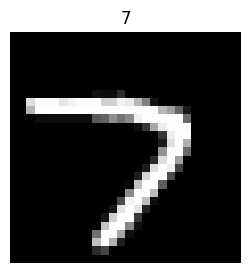

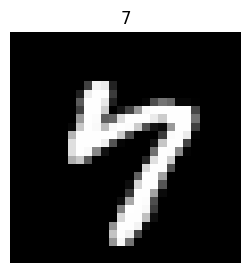

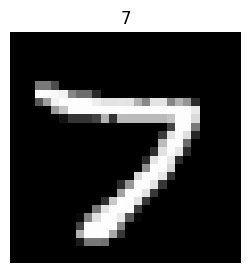

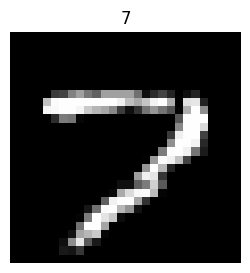

In [50]:
for idx in falsely_identified_ablation.keys():
    if falsely_identified_ablation[idx] == 1:
        visualize_image(test_images[idx], test_labels[idx])

These are a little bit weird to be identified as 0s in our ablation experiment, we really need a reliable feature reversal mechanism to better understand the "removal" of these key features.